# Exploration 

In [2]:
from pde import NeuralNet, LinearQuadraticRegulator2D, LinearQuadraticRegulator10D, LinearQuadraticRegulatorND, GenerateData, NonLinear, CuckerSmale
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import copy

In [3]:
sum([i for i in range(5)])

10

In [4]:
layers = [2, 50, 50, 50, 3]
network = NeuralNet( layers, quadraticForm=True, useAdditionalModel=False, positiveSolution=False)
gamma = {'data': 0, 'gradient': 0, 'residual': 1, 'matrix': 1}
pde = NonLinear( network, gamma )

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

# lrs = [1e-3, 5e-4, 1e-4, 5e-5]
# iterations = [1000, 2000, 4000, 8000]

resu = pde.train(
    interiorPointCount=100,
    dataPointCount=100,
    lrs=lrs,
    iterations=iterations,
    useTestData=False
    )

xInt:  torch.Size([100, 2])
xData:  torch.Size([100, 2])
0 / 3000 (0 / 1000), lr:1.0e-02, loss:5.10e+00 (data: 0.00e+00, grad: 0.00e+00, res: 6.77e-01, mat: 4.42e+00)
100 / 3000 (100 / 1000), lr:1.0e-02, loss:2.16e-01 (data: 0.00e+00, grad: 0.00e+00, res: 6.76e-02, mat: 1.48e-01)
200 / 3000 (200 / 1000), lr:1.0e-02, loss:7.98e-02 (data: 0.00e+00, grad: 0.00e+00, res: 2.52e-02, mat: 5.46e-02)
300 / 3000 (300 / 1000), lr:1.0e-02, loss:2.03e-02 (data: 0.00e+00, grad: 0.00e+00, res: 3.79e-03, mat: 1.65e-02)
400 / 3000 (400 / 1000), lr:1.0e-02, loss:9.30e-03 (data: 0.00e+00, grad: 0.00e+00, res: 2.34e-03, mat: 6.96e-03)
500 / 3000 (500 / 1000), lr:1.0e-02, loss:7.36e-03 (data: 0.00e+00, grad: 0.00e+00, res: 1.82e-03, mat: 5.54e-03)
600 / 3000 (600 / 1000), lr:1.0e-02, loss:6.60e-03 (data: 0.00e+00, grad: 0.00e+00, res: 1.36e-03, mat: 5.23e-03)
700 / 3000 (700 / 1000), lr:1.0e-02, loss:6.25e-03 (data: 0.00e+00, grad: 0.00e+00, res: 1.13e-03, mat: 5.11e-03)
800 / 3000 (800 / 1000), lr:1.0e-02

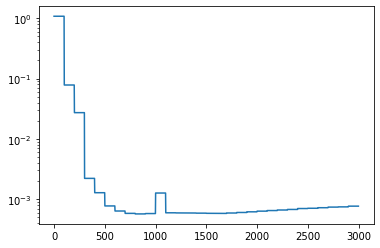

In [5]:
plt.plot( resu['mse'] )
plt.yscale('log')

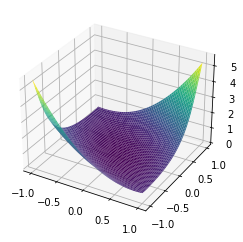

In [8]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [9]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = torch.norm( pde.network.additionalModel(space), dim=1).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

AttributeError: 'NeuralNet' object has no attribute 'additionalModel'

In [10]:
space.requires_grad = True
pde.network.computeValueFunctionDerivative(space)

tensor([[-9.2719, -5.6257],
        [-9.1916, -5.5626],
        [-9.1111, -5.4992],
        ...,
        [ 7.7667,  5.1745],
        [ 7.8297,  5.2376],
        [ 7.8927,  5.3008]], grad_fn=<AddBackward0>)

In [11]:
pde.computeHamiltonJacobiEquation(space, pde.network.computeValueFunctionDerivative(space))

tensor([[0.0735],
        [0.0774],
        [0.0819],
        ...,
        [0.1999],
        [0.1729],
        [0.1442]], grad_fn=<AddBackward0>)

In [12]:
import scipy.linalg
n_samples = 1
T = 10
dt = 0.1
# barx = torch.rand( (n_samples, 2), requires_grad=True )
barx = torch.tensor([[1., 0.7]], requires_grad=True )

B = torch.tensor([[0], [1]]).float()
Q = torch.eye(2, 2)
R = torch.eye(2, 2)

resu = {}
save_u = {}
for sample in range(n_samples):
    new_barx_i = barx[sample, :]
    save_barx_i = np.zeros( (100, 2) )
    save_u_i = np.zeros( (100, 1) )
    
    for i, t in enumerate( np.arange(0, T, dt) ):
        save_barx_i[i] = new_barx_i.detach().numpy()

        # compute the control
        barx_i = new_barx_i
        gradV = pde.network.computeValueFunctionDerivative( barx_i.reshape(1, -1) ).T
        baru = - B.T @ gradV
        
        # compute the dynamics
        A = torch.tensor([[0, 1], [barx_i[0]**2, 0]])
        new_barx_i = barx_i + A @ barx_i * dt + torch.squeeze(B @ baru) * dt

        save_u_i[i] = baru.item()
        
    resu[sample] = save_barx_i
    save_u[sample] = save_u_i

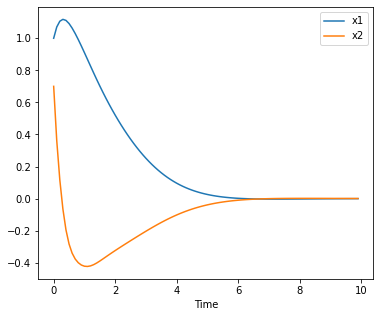

In [13]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.arange(0, T, dt), resu[0][:, 0], label='x1' )
ax.plot(np.arange(0, T, dt), resu[0][:, 1], label='x2' )
ax.set_xlabel('Position')
ax.set_xlabel('Time')
ax.legend();

In [29]:
import ray
ray.shutdown()
ray.init()

2021-12-22 12:27:42,437	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.10',
 'raylet_ip_address': '192.168.0.10',
 'redis_address': '192.168.0.10:6379',
 'object_store_address': '/tmp/ray/session_2021-12-22_12-27-40_698459_46242/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-12-22_12-27-40_698459_46242/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-12-22_12-27-40_698459_46242',
 'metrics_export_port': 64334,
 'node_id': '680843665a19ba197f2877fae2c63c9b813f5d6e9f703aaafdf94ca4'}

In [30]:
@ray.remote
def computeValueFunctionChunk(chunk_xi):
    def computeValueFunction(new_barx_i):
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i.detach().numpy()

            # compute the control
            barx_i = new_barx_i
            # gradV = np.array( [v1_deriv(barx_i[0], barx_i[1]), v2_deriv(barx_i[0], barx_i[1])] )
            gradV = pde.network.computeValueFunctionDerivative( barx_i.reshape(1, -1) ).T
            baru = - B.T @ gradV
            
            # compute the dynamics
            A = torch.tensor([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + torch.squeeze(B @ baru) * dt

            save_u_i[i] = baru.item()
            
        # compute the value function
        v = 0.5 * np.trapz(y=save_barx_i[:, 0]**2, dx=dt) + 0.5 * np.trapz(y=save_barx_i[:, 1]**2, dx=dt) + 0.5 * np.trapz(y=np.squeeze( save_u_i**2 ), dx=dt)

        return v
    
    resu = []
    for xi in chunk_xi:
        resu.append( computeValueFunction(xi) )
    return resu

In [31]:
input_params = []
for x1 in np.linspace(-1, 1, 100):
    chunk_xi = []
    for x2 in np.linspace(-1, 1, 100):
        chunk_xi.append( torch.tensor([x1, x2], requires_grad=True).float() )
    input_params.append(chunk_xi)

In [32]:
resu = []

for chunk_xi in input_params:
    resu_exp = computeValueFunctionChunk.remote(
        chunk_xi
    )
    resu.append( resu_exp )

resu = ray.get( resu )

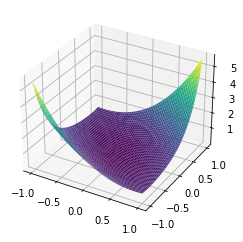

In [39]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, np.array( resu ), cmap='viridis');

In [41]:
( Z.detach().cpu().numpy() - np.array( resu ) ).mean()

0.022818319710436526

In [ ]:
pde.dataValueFunctionDerivative(space)

In [221]:
# import solution fron Matlab code (which is supposed to be a reconstruction from gradient)
Z = pd.read_csv('value_function.csv', header=None).to_numpy()

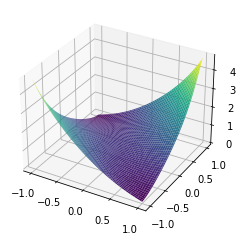

In [222]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

# Compute the function from gradient

In [1]:
a = (x^4 + 1)^0.5 * (1 + 2*(x^2 + (x^4 + 1)^0.5))^0.5 * x + (x^2 + (x^4 + 1)^0.5) * y
b = (x^2 + (x^4 + 1)^0.5) * x + (1 + 2*(x^2 + (x^4 + 1)^0.5))^0.5 * y

NameError: name 'x' is not defined

In [ ]:
# V = int a dx  + W(y)
# then we take dV/dy = int da/dy dx + W'(y) = b and we identify W ?

In [236]:
# start with a small example
f = lambda x: np.sin(x)
gradf = lambda x: np.cos(x)

In [237]:
n = 20
xlist = np.linspace(0, 5, n)
approxf = np.zeros((n, 1))

for i in range(n-1):
    approxf[i+1] = approxf[i] + (xlist[i+1] - xlist[i]) * ( gradf(xlist[i+1]) + gradf(xlist[i]) ) / 2.

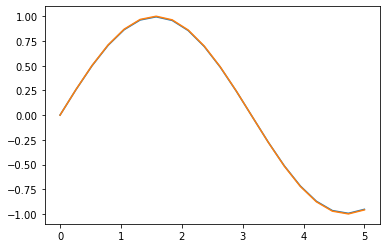

In [238]:
plt.plot( xlist, approxf )
plt.plot( xlist, f(xlist) );

In [3]:
# a 2D example
gradfx = lambda x, y: (x**4 + 1)**0.5 * (1 + 2*(x**2 + (x**4 + 1)**0.5))**0.5 * x + (x**2 + (x**4 + 1)**0.5) * y
gradfy = lambda x, y: (x**2 + (x**4 + 1)**0.5) * x + (1 + 2*(x**2 + (x**4 + 1)**0.5))**0.5 * y

In [268]:
n = 50
approxf = np.zeros((2*n, 2*n))

xlist = np.linspace(0, 1, n)
ylist = np.linspace(0, 1, n)
batch = np.zeros((n, n))
for j in range(n):
    if j < n - 1:
        batch[0, j+1] = batch[0, j] + (ylist[j+1] - ylist[j]) * ( gradfy(xlist[0], ylist[j+1]) + gradfy(xlist[0], ylist[j]) ) / 2.
    for i in range(n - 1):
        batch[i+1, j] = batch[i, j] + (xlist[i+1] - xlist[i]) * ( gradfx(xlist[i+1], ylist[j]) + gradfx(xlist[i], ylist[j]) ) / 2.
approxf[n:, n:] = batch

xlist = np.linspace(0, -1, n)
ylist = np.linspace(0, 1, n)
batch = np.zeros((n, n))
for j in range(n):
    if j < n - 1:
        batch[0, j+1] = batch[0, j] + (ylist[j+1] - ylist[j]) * ( gradfy(xlist[0], ylist[j+1]) + gradfy(xlist[0], ylist[j]) ) / 2.
    for i in range(n - 1):
        batch[i+1, j] = batch[i, j] + (xlist[i+1] - xlist[i]) * ( gradfx(xlist[i+1], ylist[j]) + gradfx(xlist[i], ylist[j]) ) / 2.
approxf[:n, n:] = batch[::-1, :]

xlist = np.linspace(0, 1, n)
ylist = np.linspace(0, -1, n)
batch = np.zeros((n, n))
for j in range(n):
    if j < n - 1:
        batch[0, j+1] = batch[0, j] + (ylist[j+1] - ylist[j]) * ( gradfy(xlist[0], ylist[j+1]) + gradfy(xlist[0], ylist[j]) ) / 2.
    for i in range(n - 1):
        batch[i+1, j] = batch[i, j] + (xlist[i+1] - xlist[i]) * ( gradfx(xlist[i+1], ylist[j]) + gradfx(xlist[i], ylist[j]) ) / 2.
approxf[n:, :n] = batch[:, ::-1]

xlist = np.linspace(0, -1, n)
ylist = np.linspace(0, -1, n)
batch = np.zeros((n, n))
for j in range(n):
    if j < n - 1:
        batch[0, j+1] = batch[0, j] + (ylist[j+1] - ylist[j]) * ( gradfy(xlist[0], ylist[j+1]) + gradfy(xlist[0], ylist[j]) ) / 2.
    for i in range(n - 1):
        batch[i+1, j] = batch[i, j] + (xlist[i+1] - xlist[i]) * ( gradfx(xlist[i+1], ylist[j]) + gradfx(xlist[i], ylist[j]) ) / 2.
approxf[:n, :n] = batch[::-1, ::-1]

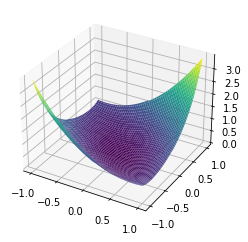

In [269]:
x = np.linspace(-1, 1, 2*n)
y = np.linspace(-1, 1, 2*n)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, approxf, cmap='viridis');

In [282]:
n = 50
approxf = np.zeros((2*n, 2*n))

xlist = np.linspace(0, 1, n)
ylist = np.linspace(0, 1, n)
batch = np.zeros((n, n))
for i in range(n):
    if i < n - 1:
        batch[i+1, 0] = batch[i, 0] + (xlist[i+1] - xlist[i]) * ( gradfx(xlist[i+1], ylist[0]) + gradfx(xlist[i+1], ylist[0]) ) / 2.
    for j in range(n - 1):
        batch[i, j+1] = batch[i, j] + (ylist[j+1] - ylist[j]) * ( gradfy(xlist[i], ylist[j+1]) + gradfy(xlist[i], ylist[j]) ) / 2.
approxf[n:, n:] = batch

xlist = np.linspace(0, -1, n)
ylist = np.linspace(0, 1, n)
batch = np.zeros((n, n))
for i in range(n):
    if i < n - 1:
        batch[i+1, 0] = batch[i, 0] + (xlist[i+1] - xlist[i]) * ( gradfx(xlist[i+1], ylist[0]) + gradfx(xlist[i+1], ylist[0]) ) / 2.
    for j in range(n - 1):
        batch[i, j+1] = batch[i, j] + (ylist[j+1] - ylist[j]) * ( gradfy(xlist[i], ylist[j+1]) + gradfy(xlist[i], ylist[j]) ) / 2.
approxf[:n, n:] = batch[::-1, :]

xlist = np.linspace(0, 1, n)
ylist = np.linspace(0, -1, n)
batch = np.zeros((n, n))
for i in range(n):
    if i < n - 1:
        batch[i+1, 0] = batch[i, 0] + (xlist[i+1] - xlist[i]) * ( gradfx(xlist[i+1], ylist[0]) + gradfx(xlist[i+1], ylist[0]) ) / 2.
    for j in range(n - 1):
        batch[i, j+1] = batch[i, j] + (ylist[j+1] - ylist[j]) * ( gradfy(xlist[i], ylist[j+1]) + gradfy(xlist[i], ylist[j]) ) / 2.
approxf[n:, :n] = batch[:, ::-1]

xlist = np.linspace(0, -1, n)
ylist = np.linspace(0, -1, n)
batch = np.zeros((n, n))
for i in range(n):
    if i < n - 1:
        batch[i+1, 0] = batch[i, 0] + (xlist[i+1] - xlist[i]) * ( gradfx(xlist[i+1], ylist[0]) + gradfx(xlist[i+1], ylist[0]) ) / 2.
    for j in range(n - 1):
        batch[i, j+1] = batch[i, j] + (ylist[j+1] - ylist[j]) * ( gradfy(xlist[i], ylist[j+1]) + gradfy(xlist[i], ylist[j]) ) / 2.
approxf[:n, :n] = batch[::-1, ::-1]

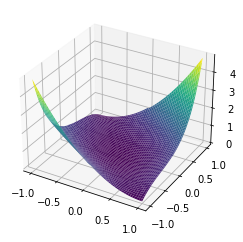

In [283]:
x = np.linspace(-1, 1, 2*n)
y = np.linspace(-1, 1, 2*n)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, approxf, cmap='viridis');

In [284]:
( approxf[0, 0] - approxf[1, 0] ) / 0.02

10.026285411051905

In [285]:
( approxf[0, 0] - approxf[0, 1] ) / 0.02

4.901828869874558

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

output_matrix = pde.network.model( pde.getEvaluationPoints().to(device) )

In [ ]:
stackedMatrices = torch.zeros((output_matrix.shape[0], dim, dim)).to(device)

inds = np.triu_indices( dim )

k = 0
for i, j in zip( inds[0], inds[1] ):
    stackedMatrices[:, i, j] = output_matrix[:, k]
    stackedMatrices[:, j, i] = output_matrix[:, k]
    k += 1

In [ ]:
# print out the matrix P

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print( stackedMatrices.mean(axis=0).cpu().detach().numpy() )

In [ ]:
a = 0.525
b = 0.366
c = -0.125
beta = 0.1

In [ ]:
print( -1 / (2*beta) * (a*a + b*b) + 2*a + 1 )
print( -1 / (2*beta) * (a*b +c*b) + 2*b)
print( -1 / (2*beta) * (c*c +b*b) + 2*c + 1)

In [ ]:
# for the linear case, the Ricatti eq is

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints().to(device) 

Z = pde.network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [ ]:
p12 = lambda x: x**2 + np.sqrt(x**4 + 1)
p22 = lambda x: np.sqrt( 1 + 2*p12(x) ) 
p11 = lambda x: (np.sqrt(x**4 + 1)) * p22(x)

xlist = np.linspace(-1, 1, 100)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot( xlist, p11(xlist), color='black' )
ax.plot( xlist, p12(xlist), color='black' )
ax.plot( xlist, p22(xlist), color='black' )

ax.fill_between( 
    x=xlist,
    y1=stackedMatrices[:, 0, 0].reshape(-1, 100).min(axis=1)[0].cpu().detach().numpy(),
    y2=stackedMatrices[:, 0, 0].reshape(-1, 100).max(axis=1)[0].cpu().detach().numpy(),
    label='p11'
) 
ax.fill_between( 
    x=xlist,
    y1=stackedMatrices[:, 0, 1].reshape(-1, 100).min(axis=1)[0].cpu().detach().numpy(),
    y2=stackedMatrices[:, 0, 1].reshape(-1, 100).max(axis=1)[0].cpu().detach().numpy(),
    label='p12'
) 
ax.fill_between( 
    x=xlist,
    y1=stackedMatrices[:, 1, 1].reshape(-1, 100).min(axis=1)[0].cpu().detach().numpy(),
    y2=stackedMatrices[:, 1, 1].reshape(-1, 100).max(axis=1)[0].cpu().detach().numpy(),
    label='p22'
) 
ax.set_xlabel('x')
ax.set_ylabel('Intensity')
ax.set_title('Coefficient of matrix P')
ax.legend();

# Train directly on P

In [ ]:
dim = 2
computeLastLasyer = lambda x: sum([i for i in range(x+1)])
layers = [dim, 20, 20, 20, computeLastLasyer(dim)]
network = NeuralNet( layers, quadraticForm=True, useAdditionalModel=False, positiveSolution=False)
gamma = {'data': 1, 'gradient': 1, 'residual': 0, 'matrix': 1}
pde = NonLinear( network, gamma, dim=dim )

In [ ]:
lrs = [1e-2, 1e-3, 1e-4]
iterations = [1000, 2000, 2000]

# lrs = [1e-3, 5e-4, 1e-4, 5e-5]
# iterations = [1000, 2000, 4000, 8000]

resu = pde.train(
    interiorPointCount=10,
    dataPointCount=20,
    lrs=lrs,
    iterations=iterations,
    )

In [ ]:
plt.plot( resu['mse'] )
plt.yscale('log')

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
space = pde.getEvaluationPoints().to(device) 
Z = pde.network.computeValueFunction(space)
Zdata = pde.dataValueFunction(space)
print( "Supervised learning: %.2e" %((Z - Zdata)**2).mean() )

In [ ]:
fig = plt.figure(figsize=(10,4))

# first plot
ax1 = fig.add_subplot(121, projection='3d')
space = pde.getEvaluationPoints().to(device) 
Z = pde.network.computeValueFunction(space).reshape(-1, 100)

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

ax1.plot_surface(X, Y, Z.detach().numpy(), cmap='viridis')
ax1.set_title('Neural net')

# second plot
ax2 = fig.add_subplot(122, projection='3d')
space = pde.getEvaluationPoints().to(device) 
Z = pde.dataValueFunction(space).reshape(-1, 100)

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

ax2.plot_surface(X, Y, Z.detach().numpy(), cmap='viridis')
ax2.set_title('Dataset');

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

output_matrix = pde.network.model( pde.getEvaluationPoints().to(device) )

In [ ]:
stackedMatrices = torch.zeros((output_matrix.shape[0], dim, dim)).to(device)

inds = np.triu_indices( dim )

k = 0
for i, j in zip( inds[0], inds[1] ):
    stackedMatrices[:, i, j] = output_matrix[:, k]
    stackedMatrices[:, j, i] = output_matrix[:, k]
    k += 1

In [ ]:
# print out the matrix P

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

print( stackedMatrices.mean(axis=0).cpu().detach().numpy() )

In [ ]:
p12 = lambda x: x**2 + np.sqrt(x**4 + 1)
p22 = lambda x: np.sqrt( 1 + 2*p12(x) ) 
p11 = lambda x: (np.sqrt(x**4 + 1)) * p22(x)

xlist = np.linspace(-1, 1, 100)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot( xlist, p11(xlist), color='black' )
ax.plot( xlist, p12(xlist), color='black' )
ax.plot( xlist, p22(xlist), color='black' )

ax.fill_between( 
    x=xlist,
    y1=stackedMatrices[:, 0, 0].reshape(-1, 100).min(axis=1)[0].cpu().detach().numpy(),
    y2=stackedMatrices[:, 0, 0].reshape(-1, 100).max(axis=1)[0].cpu().detach().numpy(),
    label='p11'
) 
ax.fill_between( 
    x=xlist,
    y1=stackedMatrices[:, 0, 1].reshape(-1, 100).min(axis=1)[0].cpu().detach().numpy(),
    y2=stackedMatrices[:, 0, 1].reshape(-1, 100).max(axis=1)[0].cpu().detach().numpy(),
    label='p12'
) 
ax.fill_between( 
    x=xlist,
    y1=stackedMatrices[:, 1, 1].reshape(-1, 100).min(axis=1)[0].cpu().detach().numpy(),
    y2=stackedMatrices[:, 1, 1].reshape(-1, 100).max(axis=1)[0].cpu().detach().numpy(),
    label='p22'
) 
ax.set_xlabel('x')
ax.set_ylabel('Intensity')
ax.set_title('Coefficient of matrix P')
ax.legend();

# Run experiment

In [ ]:
%run -i "experiments.py"

In [ ]:
# df = pd.read_pickle('experiments_linear_10d.csv')
# df_quadratic = pd.read_pickle('experiments_linear_10d_quadratic.csv')

df = pd.read_pickle('experiments/linear/linear_10d.csv')
df_quadratic = pd.read_pickle('experiments/linear/linear_10d_quadratic.csv')

In [ ]:
def computeTypes(config):
    if config['gamma']['residual'] != 0:
        if config['gamma']['data'] != 0:
            return 'data_gradient_residual'
        else:
            return 'residual'
    else:
        if config['gamma']['gradient'] != 0:
            return 'data_gradient'
        else:
            return 'data'


df['type'] = df['config'].apply(computeTypes)
resu = df.groupby('type')['mse'].apply(lambda x: np.median( np.vstack( x.to_numpy() ), axis=0 ) ).to_frame(name='mse')

df_quadratic['type'] = df_quadratic['config'].apply(computeTypes)
resu_quadratic = df_quadratic.groupby('type')['mse'].apply(lambda x: np.median( np.vstack( x.to_numpy() ), axis=0 ) ).to_frame(name='mse')

In [ ]:
resu.index = ['data (V)', 'data_gradient (V)', 'data_gradient_residual (V)']
resu_quadratic.index = ['data (P)', 'data_gradient (P)', 'data_gradient_residual (P)']

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
for idx, row in resu.iterrows():
    ax.plot(np.arange(0, 15000, 400), row['mse'][::400], label=idx)

for idx, row in resu_quadratic.iterrows():
    ax.plot(np.arange(0, 5000, 400), row['mse'][::400], label=idx)

ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean squared error')
ax.legend(loc='upper right');

## Analyse experiments

### Linear case

In [ ]:
df = pd.read_pickle('experiments_linear.csv')

In [ ]:
def computeTypes(config):
    if config['gamma']['residual'] != 0:
        if config['gamma']['data'] != 0:
            return 'data_gradient_residual'
        else:
            return 'residual'
    else:
        if config['gamma']['gradient'] != 0:
            return 'data_gradient'
        else:
            return 'data'

df['type'] = df['config'].apply(computeTypes)
resu = df.groupby('type')['mse'].apply(lambda x: np.median( np.vstack( x.to_numpy() ), axis=0 ) ).to_frame(name='mse_median')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
for idx, row in resu.iterrows():
    ax.plot(row['mse_median'], label=idx)
ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean squared error')
ax.legend(loc='upper right')
ax.set_title('Predict value function V \n (dataset: 20 points, interior: 100 points)');

In [ ]:
df = pd.read_pickle('experiments_linear_quadratic.csv')

In [ ]:
def computeTypes(config):
    if config['gamma']['residual'] != 0:
        if config['gamma']['data'] != 0:
            return 'data_gradient_residual'
        else:
            return 'residual'
    else:
        if config['gamma']['gradient'] != 0:
            return 'data_gradient'
        else:
            return 'data'

df['type'] = df['config'].apply(computeTypes)
resu = df.groupby('type')['mse'].apply(lambda x: np.median( np.vstack( x.to_numpy() ), axis=0 ) ).to_frame(name='mse_median')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
for idx, row in resu.iterrows():
    ax.plot(row['mse_median'], label=idx)
ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean squared error')
ax.legend(loc='upper right')
ax.set_title('Predict upper coefficient of matrix P \n (dataset: 5 points, interior: 10 points)' );

### Non linear case

In [ ]:
df = pd.read_pickle('experiments_non_linear.csv')

In [ ]:
def computeTypes(config):
    if config['gamma']['residual'] != 0:
        if config['gamma']['data'] != 0:
            return 'data_gradient_residual'
        else:
            return 'residual'
    else:
        if config['gamma']['gradient'] != 0:
            return 'data_gradient'
        else:
            return 'data'

df['type'] = df['config'].apply(computeTypes)
resu = df.groupby('type')['mse'].apply(lambda x: np.median( np.vstack( x.to_numpy() ), axis=0 ) ).to_frame(name='mse_median')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
for idx, row in resu.iterrows():
    ax.plot(row['mse_median'], label=idx)
ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean squared error')
ax.legend(loc='upper right')
ax.set_title('Predict value function V \n (dataset: 20 points, interior: 100 points)' );

In [ ]:
df = pd.read_pickle('experiments_non_linear_quadratic.csv')

In [ ]:
def computeTypes(config):
    if config['gamma']['residual'] != 0:
        if config['gamma']['data'] != 0:
            return 'data_gradient_residual'
        else:
            return 'residual'
    else:
        if config['gamma']['gradient'] != 0:
            return 'data_gradient'
        else:
            return 'data'

df['type'] = df['config'].apply(computeTypes)
resu = df.groupby('type')['mse'].apply(lambda x: np.median( np.vstack( x.to_numpy() ), axis=0 ) ).to_frame(name='mse_median')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
for idx, row in resu.iterrows():
    ax.plot(row['mse_median'], label=idx)
ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean squared error')
ax.legend(loc='upper right')
ax.set_title('Predict value function V \n (dataset: 10 points, interior: 50 points)' );

In [ ]:
# alternative technique: two steps learning
df = pd.read_pickle('experiments_non_linear_two_steps.csv')
resu = df['mse_residual'].apply(lambda x: np.median( np.vstack( x.to_numpy() ), axis=0 ) ).to_frame(name='mse_median')

In [ ]:
for i in range(10):
    plt.plot( np.vstack( df['mse_residual'].apply(lambda x: x.to_numpy()).to_numpy() )[i] )
plt.yscale('log')

In [ ]:
df = pd.read_pickle('experiments_non_linear_two_steps_quadratic.csv')
resu = df['mse_residual'].apply(lambda x: np.median( np.vstack( x.to_numpy() ), axis=0 ) ).to_frame(name='mse_median')

In [ ]:
for i in range(10):
    plt.plot( np.vstack( df['mse_residual'].apply(lambda x: x.to_numpy()).to_numpy() )[i] )
plt.yscale('log')

In [ ]:
# alternative technique: additional neural net
df = pd.read_pickle('experiments_non_linear_additional_nn.csv')
resu = df['mse'].apply(lambda x: np.median( np.vstack( x.to_numpy() ), axis=0 ) ).to_frame(name='mse_median')

In [ ]:
for i in range(10):
    plt.plot( np.vstack( df['mse'].apply(lambda x: x.to_numpy()).to_numpy() )[i] )
plt.yscale('log')

In [ ]:
# alternative technique: additional neural net
df = pd.read_pickle('experiments_non_linear_additional_nn_quadratic.csv')
resu = df['mse'].apply(lambda x: np.median( np.vstack( x.to_numpy() ), axis=0 ) ).to_frame(name='mse_median')

In [ ]:
for i in range(10):
    plt.plot( np.vstack( df['mse'].apply(lambda x: x.to_numpy()).to_numpy() )[i] )
plt.yscale('log')

## Compare SDRE solution with true solution

In [ ]:
layers = [2, 50, 50, 50, 3]
network = NeuralNet( layers, outputValueFunction=False, useAdditionalModel=False)
gamma = {'data': 1, 'gradient': 1, 'residual': 0}
pde = NonLinear( network, gamma )

dataGen = GenerateData(domain=([-1, 1], [-1, 1]))

In [ ]:
space = dataGen.sampleSpace()

sdre_solution = pde.dataValueFunction(space).reshape(-1, 100)
true_solution = pde.groundTruthSolution().reshape(-1, 100)

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, (true_solution - sdre_solution).detach().numpy(), cmap='viridis');

## Compute true solution for non linear

In [ ]:
layers = [2, 50, 50, 50, 3]
network = NeuralNet( layers, outputValueFunction=False, useAdditionalModel=False)
gamma = {'data': 1, 'gradient': 1, 'residual': 0}
pde = NonLinear( network, gamma )

resu = pde.train(interiorPointCount=100, dataPointCount=100, lrs=[1e-1], iterations=[2000] )

# save the weights
torch.save(pde.network.state_dict(), 'weights.pt')

In [ ]:
dataGen = GenerateData(domain=([-1, 1], [-1, 1]))
space = dataGen.sampleSpace()
Z = pde.network.computeValueFunction(space).reshape(-1, 100)

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().numpy(), cmap='viridis');

In [ ]:
gamma = {'data': 0., 'gradient': 0, 'residual': 1}
pde = NonLinear( network, gamma )

# load weights
pde.network.load_state_dict(torch.load('weights.pt'))

In [ ]:
dataGen = GenerateData(domain=([-1, 1], [-1, 1]))
space = dataGen.sampleSpace()
Z = pde.network.computeValueFunction(space).reshape(-1, 100)

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().numpy(), cmap='viridis');

In [ ]:
resu = pde.train(interiorPointCount=1, dataPointCount=50, lrs=[1e-6, 1e-7], iterations=[100000, 300000] )

In [ ]:
dataGen = GenerateData(domain=([-1, 1], [-1, 1]))
space = dataGen.sampleSpace()
Z = pde.network.computeValueFunction(space).reshape(-1, 100)

In [ ]:
# save the weights
torch.save(pde.network.state_dict(), 'trained_weights.pt')

# save the solution
pd.DataFrame( Z.detach().numpy() ).to_csv('non_linear_true.csv')

In [ ]:
dataGen = GenerateData(domain=([-1, 1], [-1, 1]))
space = dataGen.sampleSpace()
Z = pde.network.computeValueFunction(space).reshape(-1, 100)

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().numpy(), cmap='viridis');

## Experiments to compare L1 / L2 / 2 steps learning

In [ ]:
import ray
ray.init(num_cpus=6)

In [ ]:
@ray.remote
def experimentTrainingPhase(gammaData, gammaGradient, gammaResidual, interiorPointCount, dataPointCount, network_config, training_config):
    
    # network creation
    layers = network_config['layers']
    outputValueFunction = network_config['outputValueFunction']
    useAdditionalModel = network_config['useAdditionalModel']
    
    network = NeuralNet( 
        layers=layers, 
        outputValueFunction=outputValueFunction, 
        useAdditionalModel=useAdditionalModel
    )
    
    # pde creation
    gamma = {'data': gammaData, 'gradient': gammaGradient, 'residual': gammaResidual}
    pde = NonLinear( network=network, gamma=gamma )

    
    lrs = training_config['lrs']
    iterations = training_config['iterations']

    resu = pde.train(
        interiorPointCount=interiorPointCount,
        dataPointCount=dataPointCount,
        lrs=lrs,
        iterations=iterations
    )

    # final solution
    dataGen = GenerateData(domain=([-1, 1], [-1, 1]))
    space = dataGen.sampleSpace()
    Z = pde.network.computeValueFunction(space).reshape(-1, 100)

    info_dict = {}
    info_dict['Z'] = Z
    info_dict['mse'] = resu['mse']
    info_dict['loss'] = resu['loss']
    info_dict['config'] = {
        'gamma': gamma,
        'interiorPointCount': interiorPointCount,
        'dataPointCount': dataPointCount,
        'lrs': lrs,
        'iterations': iterations,
        'layers': layers,
        'outputValueFunctionv': outputValueFunction,
        'useAdditionalModel': useAdditionalModel
    }
    
    return info_dict

### additional network

In [ ]:
# configure the network
layers = [2, 20, 20, 20, 3]
outputValueFunction = False
useAdditionalModel = True

network_config = {
    'layers': layers,
    'outputValueFunction': outputValueFunction,
    'useAdditionalModel': useAdditionalModel
}

# configure the training
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
iterations = [1000, 2000, 4000, 8000]

training_config = {
    'lrs': lrs,
    'iterations': iterations,
}

In [ ]:
dataPointCount = 50
interiorPointCount = 200

params = [[0, 1, 1, interiorPointCount, dataPointCount]] * 10

In [ ]:
resu = []

for gammaData, gammaGradient, gammaResidual, interiorPointCount, dataPointCount in params:
    resu_exp = experimentTrainingPhase.remote(
        gammaData=gammaData,
        gammaGradient=gammaGradient,
        gammaResidual=gammaResidual,
        interiorPointCount=interiorPointCount,
        dataPointCount=dataPointCount,
        network_config=network_config,
        training_config=training_config
    )
    resu.append(resu_exp)

resu = ray.get(resu)
resu = pd.DataFrame(resu)
resu.to_pickle("experiment_additional_network.csv")

### all together

In [ ]:
# configure the network
layers = [2, 20, 20, 20, 3]
outputValueFunction = False
useAdditionalModel = False

network_config = {
    'layers': layers,
    'outputValueFunction': outputValueFunction,
    'useAdditionalModel': useAdditionalModel
}

# configure the training
lrs = [1e-1, 1e-2, 5e-3, 1e-3]
iterations = [1000, 2000, 4000, 8000]

training_config = {
    'lrs': lrs,
    'iterations': iterations,
}

In [ ]:
dataPointCount = 50
interiorPointCount = 200

params = [[0, 1, 0.5, interiorPointCount, dataPointCount]] * 10

In [ ]:
resu = []

for gammaData, gammaGradient, gammaResidual, interiorPointCount, dataPointCount in params:
    resu_exp = experimentTrainingPhase.remote(
        gammaData=gammaData,
        gammaGradient=gammaGradient,
        gammaResidual=gammaResidual,
        interiorPointCount=interiorPointCount,
        dataPointCount=dataPointCount,
        network_config=network_config,
        training_config=training_config
    )
    resu.append(resu_exp)

resu = ray.get(resu)
resu = pd.DataFrame(resu)
resu.to_pickle("experiment_data_residual.csv")

In [ ]:
plt.plot( resu.iloc[6]['mse'] )
plt.yscale('log')

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, resu.iloc[1]['Z'].detach().numpy(), cmap='viridis');
#ax.set_zlim(0, 1);

### two steps learning 

In [ ]:
# configure the network
layers = [2, 20, 20, 20, 3]
outputValueFunction = False
useAdditionalModel = False

network_config = {
    'layers': layers,
    'outputValueFunction': outputValueFunction,
    'useAdditionalModel': useAdditionalModel
}

# configure the training for data and residual
lrs_data = [1e-1]
iterations_data = [1000]
lrs_residual = [1e-2, 5e-3, 1e-3]
iterations_residual = [2000, 4000, 8000]

training_config = {
    'lrs_data': lrs_data,
    'iterations_data': iterations_data,
    'lrs_residual': lrs_residual,
    'iterations_residual': iterations_residual,
}

In [ ]:
@ray.remote
def twoStepsLearning(interiorPointCount, dataPointCount, network_config, training_config):
    
    # network creation
    layers = network_config['layers']
    outputValueFunction = network_config['outputValueFunction']
    useAdditionalModel = network_config['useAdditionalModel']
    
    network = NeuralNet( 
        layers=layers, 
        outputValueFunction=outputValueFunction, 
        useAdditionalModel=useAdditionalModel
    )
    
    # pde creation
    gamma_data = {'data': 1., 'gradient': 1., 'residual': 0.}
    pde = NonLinear( network=network, gamma=gamma_data )

    lrs_data = training_config['lrs_data']
    iterations_data = training_config['iterations_data']

    resu_data = pde.train(
        interiorPointCount=interiorPointCount,
        dataPointCount=dataPointCount,
        lrs=lrs_data,
        iterations=iterations_data
    )

    saved_weights = copy.deepcopy( pde.network.state_dict() )

    
    # second training
    gamma_residual = {'data': 0., 'gradient': 0., 'residual': 1.}
    pde = NonLinear( network=network, gamma=gamma_residual )

    pde.network.load_state_dict( saved_weights )

    lrs_residual = training_config['lrs_residual']
    iterations_residual = training_config['iterations_residual']

    resu_residual = pde.train(
        interiorPointCount=interiorPointCount,
        dataPointCount=dataPointCount,
        lrs=lrs_residual,
        iterations=iterations_residual
    )

    # final solution
    dataGen = GenerateData(domain=([-1, 1], [-1, 1]))
    space = dataGen.sampleSpace()
    Z = pde.network.computeValueFunction(space).reshape(-1, 100)

    info_dict = {}
    info_dict['Z'] = Z
    info_dict['mse_data'] = resu_data['mse']
    info_dict['mse_residual'] = resu_residual['mse']
    info_dict['loss_data'] = resu_data['loss']
    info_dict['loss_residual'] = resu_residual['loss']
    info_dict['config'] = {
        'gamma_data': gamma_data,
        'gamma_residual': gamma_residual,
        'interiorPointCount': interiorPointCount,
        'dataPointCount': dataPointCount,
        'lrs_data': lrs_data,
        'lrs_residual': lrs_residual,
        'iterations_data': iterations_data,
        'iterations_residual': iterations_residual,
        'layers': layers,
        'outputValueFunctionv': outputValueFunction,
        'useAdditionalModel': useAdditionalModel
    }
    
    return info_dict

In [ ]:
dataPointCount = 50
interiorPointCount = 200

params = [[interiorPointCount, dataPointCount]] * 10

In [ ]:
resu = []

for interiorPointCount, dataPointCount in params:
    resu_exp = twoStepsLearning.remote(
        interiorPointCount=interiorPointCount,
        dataPointCount=dataPointCount,
        network_config=network_config,
        training_config=training_config,
    )
    resu.append(resu_exp)

resu = ray.get(resu)
resu = pd.DataFrame(resu)
resu.to_pickle("experiment_two_steps.csv")

In [ ]:
plt.plot( resu.iloc[4]['mse_residual'] )
plt.yscale('log')

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, resu.iloc[3]['Z'].detach().numpy(), cmap='viridis');
#ax.set_zlim(0, 1);

## Analyse the results

In [ ]:
results_additional_network = pd.read_pickle('experiment_additional_network.csv')
results_data_residual = pd.read_pickle('experiment_data_residual.csv')
results_two_steps = pd.read_pickle('experiment_two_steps.csv')

In [ ]:
plt.plot( results_additional_network.loc[[i for i in range(10) if i not in [3, 7]],'mse'].apply( lambda x: x.to_numpy() ).mean()[::1000],label='Additional nn' )
plt.plot( results_data_residual['mse'].apply( lambda x: x.to_numpy() ).mean()[::1000], label='Data/grad/residual' )
plt.plot(
    np.hstack([
        results_two_steps['mse_data'].apply( lambda x: x.to_numpy() ).mean(),
        results_two_steps['mse_residual'].apply( lambda x: x.to_numpy() ).mean()
    ])[::1000], label='Two steps'
)
plt.yscale('log')
plt.xlabel('Iterations x1000')
plt.ylabel('MSE')
plt.legend();

## check derivative linear case

In [ ]:
network = NeuralNet( layers, outputValueFunction=False, useAdditionalModel=False)

dataGen = GenerateData(domain=([-1, 1], [-1, 1]))

pde = LinearQuadraticRegulator( network, gamma )

space = dataGen.sampleSpace()
space.requires_grad = True

In [ ]:
valueFunction = pde.dataValueFunction(space)
valueFunction.backward(torch.ones(10000, 1))

torch.max(pde.dataValueFunctionDerivative(space) - space.grad)

## check SDRE non linear case

In [292]:
# matlab gives: 
# p11 = lambda x:  (2*(x**4 + 1)**(1/2) + 2*x**2 + 1)**(3/2)/2 - (x**2 + 1/2)*(2*(x**4 + 1)**(1/2) + 2*x**2 + 1)**(1/2)
# p12 = lambda x:  (x**4 + 1)**(1/2) + x**2
# p22 = lambda x:  (2*(x**4 + 1)**(1/2) + 2*x**2 + 1)**(1/2)

p12 = lambda x: x**2 + (x**4 + 1)**0.5
p22 = lambda x: ( 1 + 2*p12(x) )**0.5 
p11 = lambda x: ((x**4 + 1)**0.5) * p22(x)

def matrixP(x):
    return torch.tensor([[p11(x), p12(x)], [p12(x), p22(x)]])

def equationSDRE(x):
    return (
        matrixP(x) @ torch.tensor([[0, 1], [x**2, 0]]) + torch.tensor([[0, x**2], [1, 0]]) @ matrixP(x) 
        - matrixP(x) @ torch.tensor([[0], [1]]).float().reshape(2, -1) @ torch.tensor([0, 1]).float().reshape(1, -1) @ matrixP(x) 
        + torch.eye(2)
    )

In [ ]:
x0 = 90.
print( 2 * p12(x0) * x0**2 - p12(x0)**2 + 1 )
print( p11(x0) + p22(x0)*x0**2 -p12(x0)*p22(x0)  )
print( 2*p12(x0) - p22(x0)**2 + 1  )

In [ ]:
x0 = torch.tensor([2.7]).float()

equationSDRE(x0)

In [ ]:
matrixP(x0) @ torch.tensor([[0, 1], [x0**2, 0]]) + torch.tensor([[0, x0**2], [1, 0]]) @ matrixP(x0) 

In [ ]:
- matrixP(x0) @ torch.tensor([[0], [1]]).float().reshape(2, -1) @ torch.tensor([0, 1]).float().reshape(1, -1) @ matrixP(x0)

## check the error we make on the residual

In [2]:
layers = [2, 50, 50, 50, 3]
network = NeuralNet( layers, quadraticForm=False, useAdditionalModel=False)
gamma = {'data': 1, 'gradient': 1, 'residual': 0, 'matrix': 0}
pde = NonLinear( network, gamma )

In [3]:
space = pde.getEvaluationPoints()

In [4]:
# P from SDRE but analytical derivative
gradV = pde.dataValueFunctionDerivative(space)
print(gradV[:3])
pde.computeHamiltonJacobiEquation(space, gradV)

tensor([[-12.6569,  -4.8284],
        [-12.5108,  -4.7797],
        [-12.3654,  -4.7309]])


tensor([[6.8284],
        [6.5952],
        [6.3664],
        ...,
        [6.3664],
        [6.5952],
        [6.8284]])

In [286]:
# P from SDRE but gradV = Px

p12 = lambda x: x**2 + (x**4 + 1)**0.5
p22 = lambda x: ( 1 + 2*p12(x) )**0.5 
p11 = lambda x: ((x**4 + 1)**0.5) * p22(x)

stackedMatrices = torch.zeros((space.shape[0], space.shape[1], space.shape[1]))
stackedMatrices[:, 0, 0] = p11( space[:, 0] ) 
stackedMatrices[:, 1, 1] = p22( space[:, 0] )
stackedMatrices[:, 0, 1] = p12( space[:, 0] )
stackedMatrices[:, 1, 0] = p12( space[:, 0] )

gradV = torch.einsum('nij, nj -> ni', stackedMatrices, space)
print(gradV[:3])
pde.computeHamiltonJacobiEquation(space, gradV)

tensor([[-5.8284, -4.8284],
        [-5.7797, -4.7797],
        [-5.7309, -4.7309]])


tensor([[-9.5367e-07],
        [-3.5763e-07],
        [-7.1526e-07],
        ...,
        [-7.1526e-07],
        [-3.5763e-07],
        [-9.5367e-07]])

In [287]:
import scipy.integrate as integrate
import scipy.special as special

def funa(x, y):
    return (x**4 + 1)**0.5 * (1 + 2*(x**2 + (x**4 + 1)**0.5))**0.5 * x + (x**2 + (x**4 + 1)**0.5) * y

def funb(x, y):
    return (x**2 + (x**4 + 1)**0.5) * x + (1 + 2*(x**2 + (x**4 + 1)**0.5))**0.5 * y

print( integrate.quad(lambda x: funa(x, 1), 0, 1) )
print( integrate.quad(lambda y: funb(1, y), 0, 1) )

(2.6190368152665666, 2.907714974649885e-14)
(3.621320343559642, 4.020473224963397e-14)


In [305]:
def grad_value_function(x):
    x1 = x[0]
    x2 = x[1]

    a = (x1**4 + 1)**0.5 * (1 + 2*(x1**2 + (x1**4 + 1)**0.5))**0.5 * x1 + (x1**2 + (x1**4 + 1)**0.5) * x2
    b = (x1**2 + (x1**4 + 1)**0.5) * x1 + (1 + 2*(x1**2 + (x1**4 + 1)**0.5))**0.5 * x2

    r = - 0.5 *b*b + a*x2 + b*x1*x1*x1 + 0.5*(x1*x1 + x2*x2) 

    return r

In [306]:
grad_value_function( space[0] )

tensor(-9.5367e-07)

In [295]:
gradV[0]

tensor([-5.8284, -4.8284])

In [296]:
matrixP(space[1, 0]) @ space[1]

tensor([-5.7797, -4.7797])

In [297]:
gradV[0] @ torch.tensor([[0, 1], [space[0, 0]**2, 0]]) @ space[0]

tensor(10.6569)

In [298]:
pde.computeFxTerm(space, gradV)

tensor([[10.6569],
        [10.4426],
        [10.2302],
        ...,
        [10.2302],
        [10.4426],
        [10.6569]])

In [299]:
pde.computeGxTerm(gradV)

tensor([[-11.6569],
        [-11.4226],
        [-11.1906],
        ...,
        [-11.1906],
        [-11.4226],
        [-11.6569]])

In [300]:
pde.computeLxTerm(space)

tensor([[1.0000],
        [0.9800],
        [0.9604],
        ...,
        [0.9604],
        [0.9800],
        [1.0000]])

In [301]:
xi = space[0].reshape(-1, 1)
xi

tensor([[-1.],
        [-1.]])

In [302]:
0.5 * xi.T @ (matrixP(xi[0]) @ torch.tensor([[0, 1], [xi[0]**2, 0]]) + torch.tensor([[0, xi[0]**2], [1, 0]]) @ matrixP(xi[0])) @ xi

tensor([[10.6569]])

In [303]:
0.5 * xi.T @ (- matrixP(xi[0]) @ torch.tensor([[0], [1]]).float().reshape(2, -1) @ torch.tensor([0, 1]).float().reshape(1, -1) @ matrixP(xi[0]) ) @ xi

tensor([[-11.6569]])

In [304]:
0.5 * xi.T @ torch.eye(2) @ xi

tensor([[1.]])

## Plot trajectories
we know now that Px is the real gradient that satisfies the HJ. So we can replay that and check with what we though was the real one

In [100]:
import scipy.linalg
n_samples = 1
T = 10
dt = 0.1
barx = np.random.random( (n_samples, 2) )
#barx = np.array([[1., 0.7]])

B = np.eye(2, 2)
Q = np.eye(2, 2)
R = 0.2 * np.eye(2, 2)

def trajectories_lqr():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 2) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = 2 * .69 * np.array( [barx_i[0], barx_i[1]] )
            baru = - B.T @ gradV
            print(baru)

            # compute the dynamics
            A = np.eye(2, 2)
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u

In [101]:
resu, save_u = trajectories_lqr()

[-1.21525221 -0.45214915]
[-1.16907262 -0.43496749]
[-1.12464786 -0.41843872]
[-1.08191124 -0.40253805]
[-1.04079862 -0.3872416 ]
[-1.00124827 -0.37252642]
[-0.96320084 -0.35837042]
[-0.9265992  -0.34475234]
[-0.89138843 -0.33165175]
[-0.85751567 -0.31904899]
[-0.82493008 -0.30692513]
[-0.79358273 -0.29526197]
[-0.76342659 -0.28404202]
[-0.73441638 -0.27324842]
[-0.70650856 -0.26286498]
[-0.67966123 -0.25287611]
[-0.65383411 -0.24326682]
[-0.62898841 -0.23402268]
[-0.60508685 -0.22512982]
[-0.58209355 -0.21657488]
[-0.559974   -0.20834504]
[-0.53869498 -0.20042793]
[-0.51822457 -0.19281167]
[-0.49853204 -0.18548482]
[-0.47958782 -0.1784364 ]
[-0.46136349 -0.17165582]
[-0.44383167 -0.1651329 ]
[-0.42696607 -0.15885785]
[-0.41074136 -0.15282125]
[-0.39513319 -0.14701404]
[-0.38011813 -0.14142751]
[-0.36567364 -0.13605326]
[-0.35177804 -0.13088324]
[-0.33841047 -0.12590967]
[-0.32555088 -0.12112511]
[-0.31317994 -0.11652235]
[-0.3012791 -0.1120945]
[-0.2898305  -0.10783491]
[-0.27881694 -

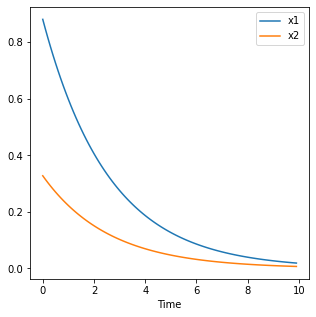

In [102]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(0, T, dt), resu[0][:, 0], label='x1' )
ax.plot(np.arange(0, T, dt), resu[0][:, 1], label='x2' )
ax.set_xlabel('Position')
ax.set_xlabel('Time')
ax.legend();

In [277]:
gradfx = lambda x, y: (x**4 + 1)**0.5 * (1 + 2*(x**2 + (x**4 + 1)**0.5))**0.5 * x + (x**2 + (x**4 + 1)**0.5) * y
gradfy = lambda x, y: (x**2 + (x**4 + 1)**0.5) * x + (1 + 2*(x**2 + (x**4 + 1)**0.5))**0.5 * y

In [5]:
p12 = lambda x: x**2 + np.sqrt(x**4 + 1)
p22 = lambda x: np.sqrt( 1 + 2*p12(x) ) 
p11 = lambda x: (np.sqrt(x**4 + 1)) * p22(x)

p12_deriv = lambda x: 2 * x * ( 1 + x**2 / np.sqrt(x**4 + 1) )
p22_deriv = lambda x: p12_deriv(x) / p22(x)
p11_deriv = lambda x: 2 * x**3 / np.sqrt(x**4 + 1) * p22(x) + np.sqrt(1 + x**4) * p22_deriv(x)

v1_deriv = lambda x, y: 0.5 * ( p11_deriv(x) * x**2 + 2 * x * p11(x) + 2*p12_deriv(x) * x * y + 2*p12(x) * y + y**2 * p22_deriv(x) )
v2_deriv = lambda x, y: p12(x) * x + p22(x) * y

In [382]:
import scipy.linalg
n_samples = 1
T = 10
dt = 0.01
barx = np.random.random( (n_samples, 2) )
barx = np.array([[1., 1.], [0.3, -0.7]])

B = np.array([[0], [1]])
Q = np.eye(2, 2)
R = np.eye(2, 2)

def trajectories_true():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (1000, 2) )
        save_u_i = np.zeros( (1000, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = np.array( [gradfx(barx_i[0], barx_i[1]), gradfy(barx_i[0], barx_i[1])] )
            baru = - B.T @ gradV
            
            # compute the dynamics
            A = np.array([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u

def trajectories_old():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = np.array( [v1_deriv(barx_i[0], barx_i[1]), v2_deriv(barx_i[0], barx_i[1])] )
            baru = - B.T @ gradV
            
            # compute the dynamics
            A = np.array([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u


In [384]:
resu, save_u = trajectories_true() 
# resu_old, save_u_old = trajectories_old() 

Text(0.5, 1.0, 'using Px')

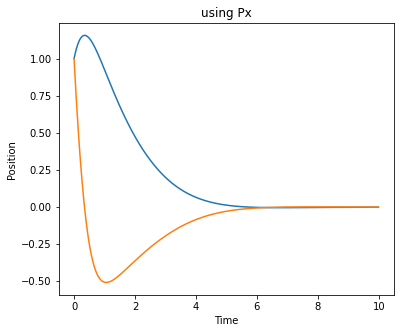

In [385]:
fig, ax = plt.subplots(figsize=(6, 5))
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), resu[sample][:, 0])
    ax.plot(np.arange(0, T, dt), resu[sample][:, 1])
ax.set_ylabel('Position')
ax.set_xlabel('Time')
ax.set_title('using Px')

Text(0.5, 1.0, 'using Px')

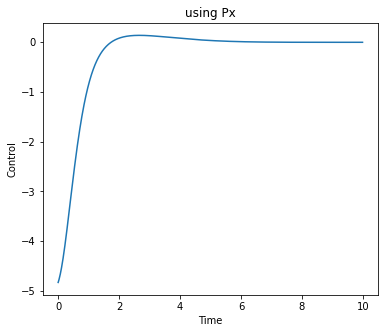

In [386]:
fig, ax = plt.subplots(figsize=(6, 5))
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), save_u[sample][:, 0])
ax.set_ylabel('Control')
ax.set_xlabel('Time')
ax.set_title('using Px')

In [387]:
def dataValueFunction( x ):
    stackedMatrices = np.zeros((x.shape[0], x.shape[1], x.shape[1]))

    p12 = lambda x: x**2 + np.sqrt(x**4 + 1)
    p22 = lambda x: np.sqrt( 1 + 2*p12(x) ) 
    p11 = lambda x: (np.sqrt(x**4 + 1)) * p22(x)

    stackedMatrices[:, 0, 0] = p11( x[:, 0] )
    stackedMatrices[:, 0, 1] = p12( x[:, 0] )
    stackedMatrices[:, 1, 0] = p12( x[:, 0] )
    stackedMatrices[:, 1, 1] = p22( x[:, 0] )

    productValueFunction = 0.5 * np.einsum('ni, nij, nj -> n', x, stackedMatrices, x).reshape(-1, 1)

    return productValueFunction

In [390]:
0.5 * np.trapz(y=resu[0][:, 0]**2, dx=dt) + 0.5 * np.trapz(y=resu[0][:, 1]**2, dx=dt) + 0.5 * np.trapz(y=np.squeeze( save_u[0]**2 ), dx=dt)

5.853441738467915

In [389]:
dataValueFunction( barx ) 

array([[5.32842712],
       [0.28837693]])

array([1., 1.])

In [187]:
np.savetxt( 'trajectories_2d_non_linear.csv',
    np.vstack( [np.arange(0, T, dt), resu[0][:, 0], resu[0][:, 1], resu[1][:, 0], resu[1][:, 1]] ).T,
    delimiter=',',
    fmt='%.6f' )

np.savetxt( 'control_2d_non_linear.csv',
    np.vstack( [np.arange(0, T, dt), save_u[0][:, 0], save_u[1][:, 0]] ).T,
    delimiter=',',
    fmt='%.6f' )

In [148]:
controlu = lambda x, y: -(x**2 + (x**4 + 1)**0.5) * x - (1 + 2*(x**2 + (x**4 + 1)**0.5))**0.5 * y

In [153]:
total_u = np.zeros((20, 20))
for i, x1 in enumerate( np.linspace(-1, 1, 20) ):
    for j, x2 in enumerate( np.linspace(-1, 1, 20) ):
        total_u[i, j] = controlu(x1, x2)

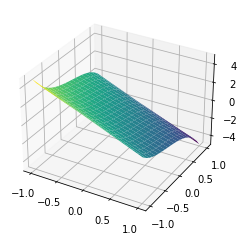

In [154]:
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_u, cmap='viridis');

In [155]:
np.savetxt( 'control_map_2d_non_linear.csv',
    np.hstack( [X.reshape(-1, 1), Y.reshape(-1, 1), total_u.reshape(-1, 1)] ),
    delimiter=',',
    fmt='%.6f' )

In [34]:
# compute V from the trajectories
# int l(x) + beta u^2

In [365]:
0.5 * np.trapz(y=resu[0][:, 0]**2, dx=dt) + 0.5 * np.trapz(y=resu[0][:, 1]**2, dx=dt) + 0.5 * np.trapz(y=np.squeeze( save_u[0]**2 ), dx=dt)

1.0533100244779232

In [188]:
def computeValueFunction(new_barx_i):
    save_barx_i = np.zeros( (100, 2) )
    save_u_i = np.zeros( (100, 1) )
    
    for i, t in enumerate( np.arange(0, T, dt) ):
        save_barx_i[i] = new_barx_i

        # compute the control
        barx_i = new_barx_i
        # gradV = np.array( [v1_deriv(barx_i[0], barx_i[1]), v2_deriv(barx_i[0], barx_i[1])] )
        gradV = np.array( [gradfx(barx_i[0], barx_i[1]), gradfy(barx_i[0], barx_i[1])] )
        baru = - B.T @ gradV
        
        # compute the dynamics
        A = np.array([[0, 1], [barx_i[0]**2, 0]])
        new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

        save_u_i[i] = baru.item()
        
    # compute the value function
    v = 0.5 * np.trapz(y=save_barx_i[:, 0]**2, dx=dt) + 0.5 * np.trapz(y=save_barx_i[:, 1]**2, dx=dt) + 0.5 * np.trapz(y=np.squeeze( save_u_i**2 ), dx=dt)

    return v

In [189]:
total_v = np.zeros((100, 100))
for i, x1 in enumerate( np.linspace(-1, 1, 100) ):
    for j, x2 in enumerate( np.linspace(-1, 1, 100) ):
        total_v[i, j] = computeValueFunction( np.array([x1, x2]) )

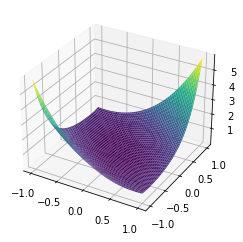

In [191]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_v, cmap='viridis');

In [63]:
np.savetxt( 'value_function_2d_non_linear.csv',
    np.hstack( [X.reshape(-1, 1), Y.reshape(-1, 1), total_v.reshape(-1, 1)] ),
    delimiter=',',
    fmt='%.6f' )

In [290]:
# check the gradients
gradvy, gradvx = np.gradient( total_v, .02, .02 )

In [314]:
interpol_gradvx(-1, -0.5)

array([-3.34996985])

In [313]:
gradfy(-1, -0.5)

-3.6213203435596424

In [315]:
from scipy import interpolate
xnode = np.linspace(-1, 1, 100)
x, y = np.meshgrid(xnode, xnode)
interpol_gradvx = interpolate.interp2d(x, y, gradvx)
interpol_gradvy = interpolate.interp2d(x, y, gradvy)

In [327]:
# and then plot again the trajectories
import scipy.linalg
n_samples = 1
T = 10
dt = 0.1
barx = np.array([[0.6, 0.5]])

B = np.array([[0], [1]])
Q = np.eye(2, 2)
R = np.eye(2, 2)

def trajectories_from_value_function():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = np.array( [interpol_gradvx(barx_i[0], barx_i[1]).item(), interpol_gradvy(barx_i[0], barx_i[1]).item()] )
            baru = - B.T @ gradV 
            
            # compute the dynamics
            A = np.array([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u


In [328]:
resu, save_u = trajectories_from_value_function()

Text(0.5, 1.0, 'using Px')

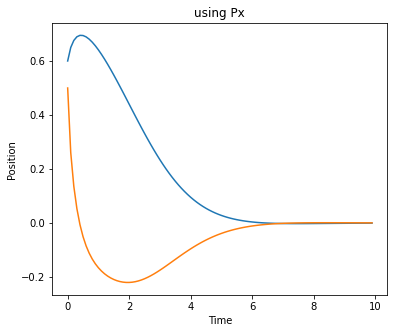

In [329]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.arange(0, T, dt), resu[0][:, 0])
ax.plot(np.arange(0, T, dt), resu[0][:, 1])
ax.set_ylabel('Position')
ax.set_xlabel('Time')
ax.set_title('using Px')

Text(0.5, 1.0, 'using Px')

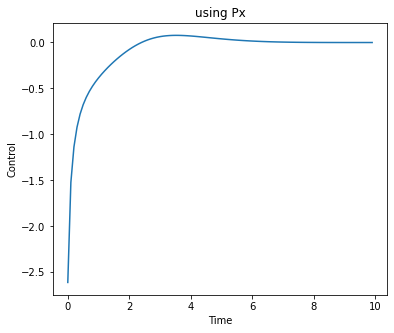

In [330]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.arange(0, T, dt), save_u[0][:, 0])
ax.set_ylabel('Control')
ax.set_xlabel('Time')
ax.set_title('using Px')

In [334]:
# we can even compute the control again:
total_u_approx = np.zeros((100, 100))
for i, x1 in enumerate( np.linspace(-1, 1, 100) ):
    for j, x2 in enumerate( np.linspace(-1, 1, 100) ):
        total_u_approx[i, j] = -interpol_gradvy(x1, x2)

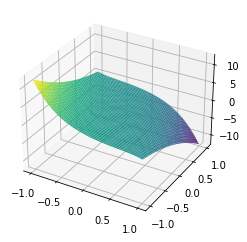

In [335]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_u_approx, cmap='viridis');

In [274]:
total_u_approx[0, 0]

6.821554397302121

In [ ]:
# now, assuming we compute the value function by using 0.5xPx, and then take the derivative, we should obtain the proper trajectories / control

In [340]:
# compute value function from SDRE
gradfx = lambda x, y: (x**4 + 1)**0.5 * (1 + 2*(x**2 + (x**4 + 1)**0.5))**0.5 * x + (x**2 + (x**4 + 1)**0.5) * y
gradfy = lambda x, y: (x**2 + (x**4 + 1)**0.5) * x + (1 + 2*(x**2 + (x**4 + 1)**0.5))**0.5 * y

In [341]:
def dataValueFunction( x ):
    stackedMatrices = torch.zeros((x.shape[0], x.shape[1], x.shape[1]))

    p12 = lambda x: x**2 + torch.sqrt(x**4 + 1)
    p22 = lambda x: torch.sqrt( 1 + 2*p12(x) ) 
    p11 = lambda x: (torch.sqrt(x**4 + 1)) * p22(x)

    stackedMatrices[:, 0, 0] = p11( x[:, 0] )
    stackedMatrices[:, 0, 1] = p12( x[:, 0] )
    stackedMatrices[:, 1, 0] = p12( x[:, 0] )
    stackedMatrices[:, 1, 1] = p22( x[:, 0] )

    productValueFunction = 0.5 * torch.einsum('ni, nij, nj -> n', x, stackedMatrices, x).reshape(-1, 1)

    return productValueFunction

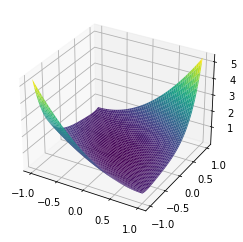

In [344]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

Z = dataValueFunction( torch.tensor( [X.reshape(-1, 1), Y.reshape(-1, 1)] ).squeeze().float().T ).reshape(-1, 100).numpy().T

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

In [129]:
np.savetxt( 'value_function_2d_non_linear_sdre.csv',
    np.hstack( [X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1) ] ),
    delimiter=',',
    fmt='%.6f' )

In [352]:
gradvx, gradvy = np.gradient( Z, .02, .02 )

In [353]:
from scipy import interpolate
xnode = np.linspace(-1, 1, 100)
x, y = np.meshgrid(xnode, xnode)
interpol_gradvx = interpolate.interp2d(x, y, gradvx)
interpol_gradvy = interpolate.interp2d(x, y, gradvy)

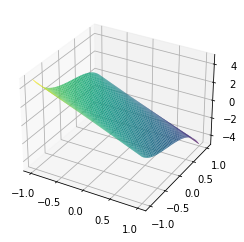

In [359]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, -gradvy, cmap='viridis');

In [363]:
# we can even compute the control again:
total_u_approx = np.zeros((100, 100))
for i, x2 in enumerate( np.linspace(-1, 1, 100) ):
    for j, x1 in enumerate( np.linspace(-1, 1, 100) ):
        total_u_approx[i, j] = -interpol_gradvy(x1, x2)

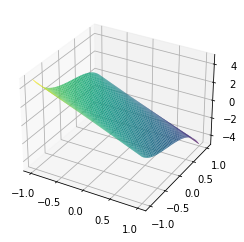

In [364]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_u_approx, cmap='viridis');

In [130]:
gradvx, gradvy = np.gradient( total_v, .02, .02 )

In [132]:
from scipy import interpolate
xnode = np.linspace(-1, 1, 100)
x, y = np.meshgrid(xnode, xnode)
interpol_gradvx = interpolate.interp2d(x, y, gradvx)
interpol_gradvy = interpolate.interp2d(x, y, gradvy)

ValueError: Invalid length for input z for non rectangular grid

In [242]:
print(gradvx[0, 0], gradvy[0, 0])

-12.27867196417054 -6.821554397302121


In [168]:
print(gradfx(-1, -1), gradfy(-1, -1))

-5.82842712474619 -4.82842712474619


In [223]:
print(v1_deriv(-1, -1), v2_deriv(-1, -1))

-12.656854249492381 -4.82842712474619


In [184]:
gradv = np.zeros((10000, 2))
gridpoints = np.zeros((10000, 2))

xlist = np.linspace(-1, 1, 100)
ylist = np.linspace(-1, 1, 100)

k = 0
for i in range(100):
    for j in range(100):
        gridpoints[k, 0] = xlist[i]
        gridpoints[k, 1] = ylist[j]

        gradv[k, 0] = gradvx[i, j]
        gradv[k, 1] = gradvy[i, j]

        gradv[k, 0] = v1_deriv(xlist[i], ylist[j])
        gradv[k, 1] = v2_deriv(xlist[i], ylist[j])

        k += 1


In [200]:
pde.computeHamiltonJacobiEquation(
    x=torch.tensor(gridpoints).float(),
    gradV=torch.tensor(gradv).float()
    )

tensor([[6.8284],
        [6.5952],
        [6.3664],
        ...,
        [6.3664],
        [6.5952],
        [6.8284]])

In [201]:
import scipy.linalg
n_samples = 1
T = 10
dt = 0.1
barx = np.random.random( (n_samples, 2) )
barx = np.array([[1., 0.7]])

B = np.array([[0], [1]])
Q = np.eye(2, 2)
R = np.eye(2, 2)

def trajectories_from_value_function():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = np.array( [interpol_gradvx(barx_i[0], barx_i[1]).item(), interpol_gradvy(barx_i[0], barx_i[1]).item()] )
            baru = - B.T @ gradV
            
            # compute the dynamics
            A = np.array([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u


In [208]:
resu_from_value_function, save_u_from_value_function = trajectories_from_value_function()

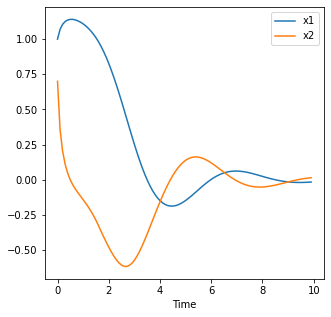

In [213]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(0, T, dt), resu_from_value_function[0][:, 0], label='x1' )
ax.plot(np.arange(0, T, dt), resu_from_value_function[0][:, 1], label='x2' )
ax.set_xlabel('Position')
ax.set_xlabel('Time')
ax.legend();

In [3]:
# we can also check the "true solution" from residual
true_sol = pd.read_csv( "non_linear_true_solution/neural_net/non_linear_true.csv" )
true_sol = true_sol[[c for c in true_sol if 'Unnamed' not in c]].to_numpy()

In [4]:
gradvx_true, gradvy_true = np.gradient( true_sol, .02, .02 )

In [5]:
print( gradvx_true[0, 0], gradvy_true[0, 0] )

-11.460379999999981 -6.129079999999965


In [6]:
from scipy import interpolate
xnode = np.linspace(-1, 1, 100)
x, y = np.meshgrid(xnode, xnode)
interpol_gradvx_true = interpolate.interp2d(x, y, gradvx_true)
interpol_gradvy_true = interpolate.interp2d(x, y, gradvy_true)

In [7]:
import scipy.linalg
n_samples = 1
T = 10
dt = 0.1
barx = np.random.random( (n_samples, 2) )
barx = np.array([[.5, 0.7]])

B = np.array([[0], [1]])
Q = np.eye(2, 2)
R = np.eye(2, 2)

def trajectories_true_sol():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = np.array( [interpol_gradvx_true(barx_i[0], barx_i[1]).item(), interpol_gradvy_true(barx_i[0], barx_i[1]).item()] )
            baru = - B.T @ gradV
            
            # compute the dynamics
            A = np.array([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u

In [8]:
resu_true_sol, save_u_true_sol = trajectories_true_sol()

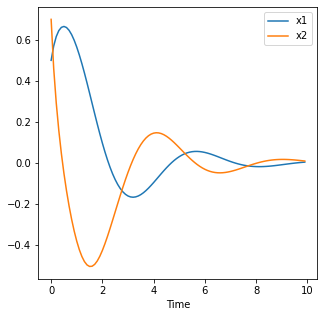

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(0, T, dt), resu_true_sol[0][:, 0], label='x1' )
ax.plot(np.arange(0, T, dt), resu_true_sol[0][:, 1], label='x2' )
ax.set_xlabel('Position')
ax.set_xlabel('Time')
ax.legend();

In [ ]:
# assuming a good control is actually P0x with P the solution of the SDRE
# we then know that gradV = Px + phi
# maybe we could retrieve P?

In [10]:
# we can also retrieve the control from matlab code
true_control = pd.read_csv( "non_linear_true_solution/semi_lagrangian/exact_control.csv" , header=None).to_numpy()[50:151, 50:151]

In [20]:
from scipy import interpolate
xnode = np.linspace(-1, 1, 101)
x, y = np.meshgrid(xnode, xnode)
interpol_control_true = interpolate.interp2d(x, y, true_control, kind='cubic')

In [26]:
import scipy.linalg
n_samples = 1
T = 10
dt = 0.1
barx = np.random.random( (n_samples, 2) )
barx = np.array([[0.4, 0.7]])

B = np.array([[0], [1]])
Q = np.eye(2, 2)
R = np.eye(2, 2)

def trajectories_true_control():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = np.array( [0, interpol_control_true(barx_i[0], barx_i[1]).item() ] )
            baru = - B.T @ gradV
            baru = interpol_control_true(barx_i[0], barx_i[1])
            print( barx_i[0], barx_i[1])
            print(baru)
            
            # compute the dynamics
            A = np.array([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u

In [27]:
resu_true_control, save_u_true_control = trajectories_true_control()

0.4 0.7
[-2.2160804]
0.47000000000000003 0.48479195979899503
[-1.69653282]
0.5184791959798996 0.32552097759624576
[-1.47595]
0.5510312937395241 0.19186377033622726
[-1.19874199]
0.5702176707731468 0.08872083713305443
[-1.1137671]
0.5790897544864522 -0.004115348089481954
[-1.06514668]
0.578678219677504 -0.09121053445547364
[-0.93376146]
0.5695571662319566 -0.16520857033428138
[-0.84016123]
0.5530363091985285 -0.23074852251365346
[-0.77529396]
0.5299614569471632 -0.29136334982497625
[-0.67807392]
0.5008251219646656 -0.3442862894598032
[-0.53229711]
0.46639649301868524 -0.384954014550118
[-0.39807438]
0.42790109156367345 -0.41461613067072556
[-0.32329303]
0.3864394784966009 -0.439110592692065
[-0.19661368]
0.34252841922739435 -0.45300104835076543
[-0.09591197]
0.2972283143923178 -0.4585735058923325
[-0.02382704]
0.25137096380308455 -0.45833035581764575
[0.04395241]
0.20553792822131997 -0.4523467684469149
[0.13722135]
0.16030325137662849 -0.4377563208602934
[0.17166141]
0.11652761929059914

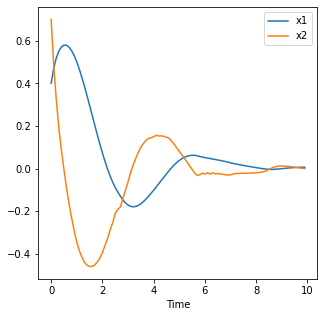

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(0, T, dt), resu_true_control[0][:, 0], label='x1' )
ax.plot(np.arange(0, T, dt), resu_true_control[0][:, 1], label='x2' )
ax.set_xlabel('Position')
ax.set_xlabel('Time')
ax.legend();

## check derivative the non linear case

In [ ]:
pde = NonLinear( network, gamma )

space = dataGen.sampleSpace()
space.requires_grad = True

In [ ]:
valueFunction = pde.dataValueFunction(space)
valueFunction.backward(torch.ones(10000, 1))

torch.max(pde.dataValueFunctionDerivative(space) - space.grad)

In [ ]:
space.grad

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, torch.norm(space.grad, dim=1).reshape(-1, 100).detach().numpy(), cmap='viridis');

## Test

In [ ]:
layers = [2, 20, 20, 1]
gamma = {'data': 1., 'gradient': 0, 'residual': 1}

network = NeuralNet( layers, outputValueFunction=True, useAdditionalModel=False)
pde = NonLinear( network, gamma )

resu = pde.train(interiorPointCount=50, dataPointCount=50, lrs=[1e-2, 5e-3], iterations=[4000, 11000] )

In [ ]:
plt.plot(resu['loss'])
plt.yscale('log')

In [ ]:
dataGen = GenerateData(domain=([-1, 1], [-1, 1]))
space = dataGen.sampleSpace()
Z = pde.network.computeValueFunction(space).reshape(-1, 100)

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().numpy(), cmap='viridis');
#ax.set_zlim(0, 1);

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, pde.groundTruthSolution().reshape(-1, 100).numpy(), cmap='viridis');
#ax.set_zlim(0, 1);

In [ ]:
def loadData(solutionFilename='exact_solution.csv', xnodeFilename='xnode.csv'):
    outputSolution = pd.read_csv(solutionFilename, header=None).iloc[1:-1, 1:-1].to_numpy()
    xnode = pd.read_csv(xnodeFilename, header=None).to_numpy().flatten()[1:-1]
    return outputSolution, xnode

def interpolateData(xnode, outputSolution):
    from scipy import interpolate
    x, y = np.meshgrid(xnode, xnode)
    f = interpolate.interp2d(x, y, outputSolution)
    xspace = np.linspace(-1, 1, 100)
    interpolatedSolution = f(xspace, xspace)
    return torch.tensor(interpolatedSolution).reshape(-1, 1)

outputSolution, xnode = loadData()

In [ ]:
outputSolution.shape

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 99)
y = np.linspace(-1, 1, 99)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, outputSolution, cmap='viridis');
#ax.set_zlim(0, 1);

## Test additional model

In [ ]:
layers = [2, 20, 20, 20, 3]
gamma = {'data': 0., 'gradient': 1, 'residual': 1}

network = NeuralNet( layers, outputValueFunction=False, useAdditionalModel=True)
pde = NonLinear( network, gamma )

resu = pde.train(interiorPointCount=200, dataPointCount=50, lrs=[1e-1, 1e-2, 1e-3, 1e-4], iterations=[1000, 2000, 4000, 8000] )

In [ ]:
plt.plot(resu['mse'])
plt.yscale('log')

In [ ]:
dataGen = GenerateData(domain=([-1, 1], [-1, 1]))
space = dataGen.sampleSpace()
Z = pde.network.computeValueFunction(space).reshape(-1, 100)

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().numpy(), cmap='viridis');
#ax.set_zlim(0, 1);

In [ ]:
Zadd = torch.norm(pde.network.additionalModel(space), dim=1).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Zadd.detach().numpy(), cmap='viridis');
#ax.set_zlim(0, 1);

## Simulate the SDRE on -2:2 to put default value on Dante's solver

In [ ]:
layers = [2, 50, 50, 50, 3]
network = NeuralNet( layers, outputValueFunction=False, useAdditionalModel=False)
gamma = {'data': 1, 'gradient': 1, 'residual': 0}
pde = NonLinear( network, gamma )

def sampleSpace(nPoint=100, xlim=1, dim=2):
    space = np.meshgrid( *[np.linspace(-xlim, xlim, nPoint) for i in range(dim)] )
    space = torch.tensor( list(space) ).T.float().reshape(-1, dim)
    return space

In [ ]:
space = sampleSpace(nPoint=100, xlim=2, dim=2)

In [ ]:
sdre_value_function = pde.dataValueFunction(space).reshape(-1, 100)

In [ ]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, sdre_value_function.detach().numpy(), cmap='viridis');

In [ ]:
# load the solution from Dante
df_exact_solution = pd.read_csv('exact_solution.csv', header=None)

In [ ]:
xnode = pd.read_csv('xnode.csv', header=None).iloc[0].to_numpy()

In [ ]:
df_exact_solution.columns = xnode
df_exact_solution.index = xnode
df_exact_solution = df_exact_solution.iloc[ 50:151, 50:151 ]

In [ ]:
x = np.linspace(-1, 1, 101)
y = np.linspace(-1, 1, 101)

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, df_exact_solution.to_numpy(), cmap='viridis');

In [ ]:
def interpolateData(xnode, outputSolution):
    from scipy import interpolate
    x, y = np.meshgrid(xnode, xnode)
    f = interpolate.interp2d(x, y, outputSolution)
    xspace = np.linspace(-1, 1, 100)
    interpolatedSolution = f(xspace, xspace)
    return torch.tensor(interpolatedSolution).reshape(-1, 1)

In [ ]:
df_exact_solution_re = interpolateData( xnode[50:151], df_exact_solution )

In [ ]:
# check the difference with the SDRE solution
layers = [2, 50, 50, 50, 3]
network = NeuralNet( layers, outputValueFunction=False, useAdditionalModel=False)
gamma = {'data': 1, 'gradient': 1, 'residual': 0}
pde = NonLinear( network, gamma )

dataGen = GenerateData(domain=([-1, 1], [-1, 1]))
space = dataGen.sampleSpace()

sdre_solution = pde.dataValueFunction(space).reshape(-1, 100)
true_solution = pde.groundTruthSolution().reshape(-1, 100)

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

Z = ( df_exact_solution_re.reshape(-1, 100) - sdre_solution ).detach().numpy()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

Z = ( (df_exact_solution_re - df_exact_solution_re.min()).reshape(-1, 100) - true_solution ).detach().numpy()
print( (Z**2).mean() )

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

In [ ]:
from scipy import interpolate
x, y = np.meshgrid(xnode[50:151], xnode[50:151])
f_dante = interpolate.interp2d( x, y, df_exact_solution.to_numpy() )

In [ ]:
# can we put the solution in the HJ eq?
def danteSolution(xNew):
    return f_dante(xNew[0], xNew[1])

In [ ]:
dante_solution_grad = np.gradient(
    df_exact_solution_re.detach().numpy().reshape(-1, 100),
    2. / 99 )
dante_solution_grad = np.array( dante_solution_grad ).reshape(2, 10000).T

In [ ]:
# apply equation on it
gx = pde.computeGxTerm( torch.tensor(dante_solution_grad).float() )
fx = pde.computeFxTerm( space, torch.tensor(dante_solution_grad).float() )
lx = pde.computeLxTerm( space )

In [ ]:
hjeq = gx + fx + lx

In [ ]:
(hjeq**2).mean()

## Semi Lagrangian scheme for ground truth solution

In [ ]:
def printMatrix(mat):
    print('\n'.join([''.join(["%.2f "%item for item in row]) for row in mat]))
    print('\n')

In [ ]:
import scipy.interpolate as interpolate
x = 1
deltax = 0.025
xnode = np.arange(-1, 1 + deltax, deltax)

X, Y = np.meshgrid(xnode, xnode)
h = .05 * deltax
ncont = 200
discount_factor = 0.001
dim = len(xnode)

Vold = np.ones( (dim, dim) )
inside = np.ones( (dim, dim, ncont) )
inside[1:dim-1, 1:dim-1, :] = 0
Vold[ X**2 + Y**2 == 0 ] = 0
Tg = Vold

aold = np.zeros((dim, dim))

count = 0
cb = 7 #control bounds to look for a control variables in [-cb cb]

Acont = np.arange(-cb, cb +(2 * cb / (ncont - 1)), (2 * cb / (ncont - 1)))

Varr = np.zeros( (dim, dim) )
Disc = np.zeros( (dim, dim) )

T = np.zeros( (dim, dim, ncont) )
Valuesvi = np.zeros( (dim, dim, dim) )

diff1 = 1
tol = 1. / 5 * deltax**2

gamma = 0.5
Disc = 0.5 * (X**2 + Y**2)

In [ ]:
while diff1 > tol:
    VI = Vold
    #printMatrix(VI)
    diff = 1
    arrx = X + h * Y
    arry = Y + h * (X**3 + aold)
    
    #print('Start inner while loop')
    while diff > tol:
        Varr = interpolate.interpn(
            points=(X[0], Y[:, 0]),
            values=Vold,
            xi=np.vstack([arrx.ravel(), arry.ravel()]).T,
            bounds_error=False,
            fill_value=5.
        ).reshape(-1, dim)
        #printMatrix(Varr)
        Vnew = np.exp(-discount_factor * h) * Varr + h * ( Disc + gamma * aold**2 )
        Vnew[Tg == 0] = 0
        diff = np.max(np.abs(Vnew - Vold)) 
        #print('diff', diff)
        Vold = Vnew
    
    #print('End inner while loop')

    for k in range(ncont):
        arrx = X + h * Y
        arry = Y + h * (X**3 + Acont[k])
        Varr = interpolate.interpn(
            points=(X[0], Y[:, 0]),
            values=Vold,
            xi=np.vstack([arrx.ravel(), arry.ravel()]).T,
            bounds_error=False,
            fill_value=1.
        ).reshape(-1, dim)
        T[:, :, k] = np.exp(-discount_factor * h) * Varr + h * (Disc + gamma * np.abs(Acont[k])**2 )
    
    #print('Last T')
    #printMatrix(T[:,:, -1])

    T[inside == 1] = 5
    donde = np.argmin(T, axis=2)
    #print(donde)
    #print('first aold')
    #printMatrix(aold)
    for i in range(ncont):
        aold[donde == i] = Acont[i]
    #print('second aold')
    #printMatrix(aold)
    #printMatrix(Varr)
    diff1 = np.max(np.abs(VI - Vold)) 
    #print('diff1', diff1)
    count = count + 1

In [ ]:
X, Y = np.meshgrid(xnode, xnode)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Vold, cmap='viridis');

## Solve SDRE for non analytical case

In [ ]:
# ORIGINAL CODE FROM ANA

import numpy as np

import numpy as np
import scipy.linalg
 
def lqr(A,B,Q,R):
    """Solve the continuous time lqr controller.
    dx/dt = A x + B u
    cost = integral x.T*Q*x + u.T*R*u
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
    
    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(R) * (B.T * X))
    
    eigVals, eigVecs = scipy.linalg.eig(A - B * K)
    
    return K, X, eigVals
 
def dlqr(A,B,Q,R):
    """Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    #ref Bertsekas, p.151
    
    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    
    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*X*B+R)*(B.T*X*A))
    
    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
    
    return K, X, eigVals

T = 10
dt = 0.1
# Set x to be the collocation points we also use in the NN (so where we want to get the value)
dim = 20 # dimension of problem
n_samples = 20 # number of samples
x = np.random.uniform(-3,3,size=(2*dim, 1, n_samples)) # i need this to be an array like so: [y_1,...,y_10,v_1,...v_10]; then the multiplication with A and stuff works out
u = np.zeros((dim, n_samples)) # u will be solved for each [y_1,...,y_10,v_1,...v_10] in the n_samples
V = np.zeros((n_samples))
gradV = np.zeros((2*dim, n_samples))

barx = x
for sample in range(0,n_samples): # I do it now per sample
    print(sample)
    barx_i = barx[:,:,sample]
    for t in np.arange(0,T,dt):
        # Solve optimal control ARE
        A_small = np.zeros((dim,dim))
        # this can be done smarter but i'm doing it the lazy way; actually it doesnt matter much cause its a tiny matrix anyways
        y = barx_i[0:dim] # first dim elements are the y elements
        for i in range(0,dim):
            for j in range(0,dim):
                if i==j:
                    A_small[i,j] = 0
                    for k in range(0,dim):
                        A_small[i,j] += -1/dim * 1/(1+(y[i]-y[k])**2)
                else:
                    A_small[i,j] = 1/dim * 1/(1+(y[i]-y[j])**2)
        A = np.bmat([[np.zeros((dim,dim)), np.eye(dim,dim)],[np.zeros((dim,dim)), A_small]]) # matrix of size 2dim x 2dim
        B = np.bmat([[np.zeros((dim,dim))], [np.eye(dim,dim)]]) # matrix of size 2*dim x dim
        Q = 1/dim * np.eye(2*dim,2*dim)
        K, S, E = lqr(A, B, Q, np.eye(dim, dim)) # S is the solution of Riccati (our P)
        # Compute new u 
        u[:,sample] = np.array((- B.T @ S @ x[:,:,sample]).T)[0] # note we use here the original x
        baru = - B.T @ S @ barx_i
        # Compute barx
        barx_i += A @ barx_i * dt + B @ baru * dt #dynamics; not sure if I should use u here over original or u evaluated in barx... now i do the latter
        # Compute V and gradV; not sure I do this the right way... cause I evaluate them in original x
        V[sample] = x[:,:,sample].T @ S @ x[:,:,sample]
        gradV[:,sample] = x[:,:,sample].T @ S


# Evaluate
chosen_sample = 0
x_eval = x[:,chosen_sample]
u_eval = u[chosen_sample]
V_eval = V[chosen_sample]
gradV_eval = gradV[:,chosen_sample]
print(u_eval)
print(V_eval)
print(gradV_eval)

### Revised code

In [ ]:
import numpy as np
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt
 
def lqr(A, B, Q, R):
    """ Solve the continuous time lqr controller.
    dx/dt = A x + B u
    cost = integral x.T*Q*x + u.T*R*u
    """
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)
    K = scipy.linalg.inv(R) @ (B.T @ P)
    
    return P, K

def buildMatrixA(y):
    """ Build the small matrix A in 
    A_big = [[0,    I   ],
             [0, A_small]]
    """
    interationCoefficient = lambda yi, yj:  1. / ( 1. + (yi - yj)**2 )
    A_small = np.zeros( (dim, dim) )
    for i in range(dim):
        for j in range(dim):
            if i == j:
                sum_coeff = sum( [interationCoefficient(yi=y[i], yj=y[k]) for k in range(dim)] )
                A_small[i, j] = -1 / dim *  sum_coeff
            else:
                A_small[i, j] = 1 / dim * interationCoefficient(yi=y[i], yj=y[j])

    return A_small

In [ ]:
T = 10
dt = 0.1
# Set x to be the collocation points we also use in the NN (so where we want to get the value)
dim = 1 # dimension of problem
n_samples = 20 # number of samples
x = np.random.uniform( 0, 0.4, size=(2 * dim, 1, n_samples) ) # i need this to be an array like so: [y_1,...,y_10,v_1,...v_10]; then the multiplication with A and stuff works out
u = np.zeros( ( dim, n_samples ) ) # u will be solved for each [y_1,...,y_10,v_1,...v_10] in the n_samples
V = np.zeros( ( n_samples ) )
gradV = np.zeros( ( 2 * dim, n_samples ) )

In [ ]:
barx = x
resu = {}

for sample in range(0, n_samples): # I do it now per sample
    print(sample)
    barx_i = barx[:,:,sample]

    save_barx_i = []

    for t in np.arange(0, T, dt):
    
        # Generate the matrices A, B, Q, R
        A_small = buildMatrixA(y=barx_i[0 : dim])
        A = np.block( [[ np.zeros((dim, dim)), np.eye(dim, dim)], [np.zeros((dim, dim)), A_small]] ) # matrix of size 2dim x 2dim
        B = np.block( [[np.zeros((dim,dim))], [np.eye(dim,dim)]] ) # matrix of size 2*dim x dim
        Q = 1 / dim * np.eye(2 * dim, 2 * dim)
        R = 1 / dim * np.eye(dim, dim)

        # Solve optimal control ARE
        P, K = lqr(A, B, Q, R) # S is the solution of Riccati (our P)

        # Compute new u 
        u[:, sample] = np.array((- B.T @ P @ x[:,:,sample]).T)[0] # note we use here the original x
        baru = - B.T @ P @ barx_i
        
        # Compute barx
        barx_i += A @ barx_i * dt + B @ baru * dt #dynamics; not sure if I should use u here over original or u evaluated in barx... now i do the latter
        
        # Compute V and gradV; not sure I do this the right way... cause I evaluate them in original x
        V[sample] = 0.5 * x[:, :, sample].T @ P @ x[:, :, sample]
        gradV[:,sample] = x[:,:,sample].T @ P

        info_dict = {'yi': barx_i[0].item(), 'vi': barx_i[1].item(), 'time': t}
        save_barx_i.append(info_dict)
    
    resu[sample] = pd.DataFrame( save_barx_i )

In [ ]:
for i in range(n_samples):
    plt.plot( resu[i]['time'], resu[i]['yi'] )

In [ ]:
for i in range(n_samples):
    plt.plot( resu[i]['time'], resu[i]['vi'] )

In [ ]:
# Evaluate
chosen_sample = 0
x_eval = x[:,chosen_sample]
u_eval = u[chosen_sample]
V_eval = V[chosen_sample]
gradV_eval = gradV[:,chosen_sample]
print(u_eval)
print(V_eval)
print(gradV_eval)

### Generate the dataset

In [10]:
import numpy as np
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt

def buildMatrixA(y):
    """ Build the small matrix A in 
    A_big = [[0,    I   ],
             [0, A_small]]
    """
    interationCoefficient = lambda yi, yj:  1. / ( 1. + (yi - yj)**2 )
    A_small = np.zeros( (dim, dim) )
    for i in range(dim):
        for j in range(dim):
            if i == j:
                sum_coeff = sum( [interationCoefficient(yi=y[i], yj=y[k]) for k in range(dim)] )
                A_small[i, j] = -1 / dim *  sum_coeff
            else:
                A_small[i, j] = 1 / dim * interationCoefficient(yi=y[i], yj=y[j])

    return A_small

def computeValueFunction(B, Q, R, barx_i):
    A_small = buildMatrixA(y=barx_i[0 : dim])
    A = np.block( [[ np.zeros((dim, dim)), np.eye(dim, dim)], [np.zeros((dim, dim)), A_small]] )
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)
    V = 0.5 * (barx_i.T @ P @ barx_i)
    gradV = P @ barx_i
    return P, V, gradV

In [6]:
dim = 2
n_samples = 100
x = np.random.uniform( -3, 3, size=(2 * dim, 1, n_samples) )

B = np.block( [[np.zeros((dim,dim))], [np.eye(dim,dim)]] )
Q = 1 / dim * np.eye(2 * dim, 2 * dim)
R = 1 / dim * np.eye(dim, dim)

In [ ]:
import ray
ray.shutdown()
ray.init()

In [ ]:
@ray.remote
def generateDatasetValues(x_chunk):
    inds = np.triu_indices( 2*dim )
    resu_P = []
    resu_V = []
    resu_gradV = []
    total_sample = x_chunk.shape[2]
    for sample in range( total_sample ):
        if sample % 500 == 0:
            print('%d / %d'%(sample, total_sample))
        barx_i = x_chunk[:, :, sample]
        P, V, gradV = computeValueFunction(B, Q, R, barx_i)
        resu_P.append( P[inds] )
        resu_V.append(V)
        resu_gradV.append(gradV)

    return resu_P, resu_V, resu_gradV

In [ ]:
input_params = []
chunk_size = 100
for i in range( 1 ):
    idx_start = i * chunk_size
    idx_end = (i + 1) * chunk_size
    print( idx_start, idx_end)
    input_params.append( x[:, :, idx_start : idx_end] )

In [ ]:
resu = []

for x_chunk in input_params:
    resu_exp = generateDatasetValues.remote(
        x_chunk
    )
    resu.append( resu_exp )

resu = ray.get( resu )

In [ ]:
resu_P = []
resu_V = []
resu_gradV = []

for resu_chunk in resu:
    chunk_P, chunk_V, chunk_gradV = resu_chunk
    resu_P += chunk_P
    resu_V += chunk_V
    resu_gradV += chunk_gradV

resu_P = np.stack( resu_P )
resu_V = np.stack( resu_V )[:,:,0]
resu_gradV = np.stack( resu_gradV )[:,:,0]

In [ ]:
np.savetxt( 'sampledPoints.csv', np.squeeze( x ).T, fmt='%.8f' )
np.savetxt( 'matrixFunction.csv', resu_P, fmt='%.8f' )
np.savetxt( 'valueFunction.csv', resu_V, fmt='%.8f' )
np.savetxt( 'valueFunctionDerivative.csv', resu_gradV, fmt='%.8f' )

## Test the generated data

In [2]:
from pde import NeuralNet, LinearQuadraticRegulator, GenerateData, NonLinear, CuckerSmale
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import copy
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
xi = torch.tensor( np.loadtxt( 'sampledPoints.csv' ) ).float().to(device)
resu_v = torch.tensor( np.loadtxt( 'valueFunction.csv' ) ).float().to(device)
resu_gradV = torch.tensor( np.loadtxt( 'valueFunctionDerivative.csv' ) ).float().to(device)
print(xi.shape)
print(resu_v.shape)
print(resu_gradV.shape)

In [ ]:
dim = 1
layers = [2 * dim, 50, 50, 50, 1]
network = NeuralNet( layers, quadraticForm=False, useAdditionalModel=False)
gamma = {'data': 0, 'gradient': 0., 'residual': 1}
pde = CuckerSmale( network, gamma, dim=dim )

In [ ]:
# verify the solution in the HJ equation
# we need the xi and gradV(xi)

In [ ]:
pde.computeHamiltonJacobiEquation(xi, resu_gradV )[:10]

In [ ]:
print( xi[:1] )
print( resu_gradV[:1] )

In [ ]:
pde.computeGxTerm(resu_gradV[:1])

In [ ]:
pde.computeLxTerm(xi[:1])

In [ ]:
pde.computeFxTerm( xi[:1], resu_gradV[:1] )

## Simple example in 2D

In [63]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

X, Y = np.meshgrid(x, y)

In [71]:
def computeValueFunction(B, Q, R, barx_i):
    A_small = -1
    A = np.block( [[ np.zeros((dim, dim)), np.eye(dim, dim)], [np.zeros((dim, dim)), A_small]] )
    print(A)
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)
    V = 0.5 * (barx_i.T @ P @ barx_i)
    gradV = P @ barx_i
    return P, V, gradV

In [72]:
dim = 1

B = np.block( [[np.zeros((dim,dim))], [np.eye(dim,dim)]] )
Q = 1 / dim * np.eye(2 * dim, 2 * dim)
R = 1 / dim * np.eye(dim, dim)

matrixV = np.zeros( (100, 100) )

for i, xi in enumerate(x):
    if i % 10 == 0:
        print(i)
    for j, yi in enumerate(y):
        barx_i = np.array([xi, yi])
        _, V, _ = computeValueFunction(B, Q, R, barx_i.reshape(-1, 1))
        matrixV[i, j] = V.item()

0
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 0. -1.]]
[[ 0.  1.

KeyboardInterrupt: 

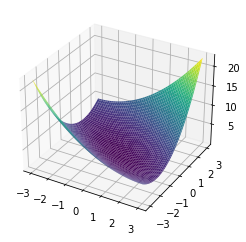

In [68]:
# true solutin
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, matrixV, cmap='viridis');

In [69]:
from itertools import product
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xinput = np.array([barx_i for barx_i in list( product(x, y) )])

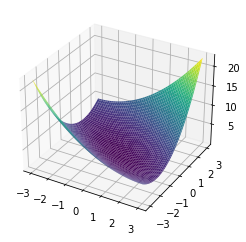

In [70]:
P = np.array([[2., 1], [1, 1.]])
Z = 0.5 * np.einsum('ni, ij, nj -> n', xinput, P, xinput).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

## Cucker Smale

In [ ]:
from pde import NeuralNet, LinearQuadraticRegulator, GenerateData, NonLinear, CuckerSmale
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import copy
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
dim = 2
layers = [2 * dim, 50, 50, 50, 10]
network = NeuralNet( layers, quadraticForm=True, useAdditionalModel=False)
gamma = {'data': 0., 'gradient': 0., 'residual': 0, 'matrix': 1}
pde = CuckerSmale( network, gamma, dim=dim )

In [ ]:
resu = pde.train(interiorPointCount=100, dataPointCount=100, lrs=[1e-3, 1e-4], iterations=[5000, 0], useTestData=True )

In [ ]:
plt.plot( resu['mse'] )
plt.yscale('log')

In [ ]:
# Plot for 2D case

# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# from itertools import product
# x = np.linspace(-3, 3, 100)
# y = np.linspace(-3, 3, 100)
# X, Y = np.meshgrid(x, y)

# xinput = np.array([barx_i for barx_i in list( product(x, y) )])

# Z = pde.network.computeValueFunction(torch.tensor(xinput).float().to(device)).reshape(-1, 100)

# ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [ ]:
# Zadd = torch.norm(pde.network.additionalModel(torch.tensor(xinput).float().to(device)), dim=1).reshape(-1, 100)

# ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, Zadd.detach().cpu().numpy(), cmap='viridis');

In [ ]:
s

In [ ]:
# lets try a two steps learning
# pde creation

dim = 2
layers = [2 * dim, 50, 50, 50, 10]
network = NeuralNet( layers, quadraticForm=True, useAdditionalModel=False)
gamma = {'data': 0., 'gradient': 0., 'residual': 0, 'matrix': 1}
pde = CuckerSmale( network, gamma, dim=dim )

In [ ]:
resu = pde.train(interiorPointCount=100, dataPointCount=100, lrs=[1e-3, 1e-4], iterations=[5000, 5000], useTestData=True )

In [ ]:
# plot in 2d case

# from itertools import product
# x = np.linspace(-3, 3, 100)
# y = np.linspace(-3, 3, 100)
# X, Y = np.meshgrid(x, y)
# xinput = np.array([barx_i for barx_i in list( product(x, y) )])

# # final solution
# Z = pde.network.computeValueFunction(torch.tensor(xinput).float().to('cuda:0')).reshape(-1, 100)
# ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis')

In [ ]:
saved_weights = copy.deepcopy( pde.network.state_dict() )

In [ ]:
# second training
gamma = {'data': 0., 'gradient': 0., 'residual': 1, 'matrix': 0.}
pde = CuckerSmale( network, gamma, dim=dim )

pde.network.load_state_dict( saved_weights )

In [ ]:
resu = pde.train(interiorPointCount=200, dataPointCount=100, lrs=[5e-4, 1e-4, 5e-5], iterations=[5000, 5000, 10000], useTestData=True )

In [ ]:
plt.plot( resu['loss'] )
plt.yscale('log')

In [ ]:
# readjust with V(0) = 0
Z0 = pde.network.computeValueFunction(torch.zeros((1, 2 * dim)).to('cuda:0'))

In [ ]:
# final solution
Z = pde.network.computeValueFunction(torch.tensor(xinput).float().to('cuda:0')).reshape(-1, 100) - Z0
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis')

In [ ]:
# check the control obtained
# we take the derivative of the neural network wrt to the input gradV
# then we can compute the control u = - 1 / (2 beta) * g^T(x) gradV(x)

In [ ]:
import scipy.linalg
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_samples = 1
T = 10
dt = 0.1
barx = torch.rand((n_samples, 2 * dim), requires_grad=True).to(device)
B = torch.tensor( np.block([[np.zeros((dim, dim))], [np.eye(dim)]]) ).float().to(device)
Q = 1 / dim * np.eye(2 * dim, 2 * dim)
R = 1 / dim * np.eye(dim, dim)
beta = 0.25

def buildMatrixA(y):
    """ Build the small matrix A in 
    A_big = [[0,    I   ],
             [0, A_small]]
    """
    interationCoefficient = lambda yi, yj:  1. / ( 1. + (yi - yj)**2 )
    A_small = np.zeros( (dim, dim) )
    for i in range(dim):
        for j in range(dim):
            if i == j:
                sum_coeff = sum( [interationCoefficient(yi=y[i], yj=y[k]) for k in range(dim)] )
                A_small[i, j] = -1 / dim *  sum_coeff
            else:
                A_small[i, j] = 1 / dim * interationCoefficient(yi=y[i], yj=y[j])

    return A_small



def computeTrajectoriesNeuralNet():
    resu = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2 * dim) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            # compute the control
            barx_i = new_barx_i
            gradV = pde.network.computeValueFunctionDerivative( barx_i.reshape(1, -1) ).T
            baru = - dim * 1 / (4 * beta) * B.T @ gradV
            
            # compute the dynamics
            A_small = buildMatrixA(y=barx_i[0 : dim])
            A = torch.tensor( np.block( [[ np.zeros((dim, dim)), np.eye(dim)], [np.zeros((dim, dim)), A_small]] ) ).float().to(device)
            new_barx_i = barx_i + A @ barx_i * dt + torch.squeeze(B @ baru) * dt

            save_barx_i[i] = new_barx_i.detach().cpu().numpy()
            
        resu[sample] = save_barx_i
    return resu

def computeTrajectoriesSDRE():
    resu = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2 * dim) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            barx_i = new_barx_i
            A_small = buildMatrixA(y=barx_i[0 : dim])
            A = torch.tensor( np.block( [[ np.zeros((dim, dim)), np.eye(dim)], [np.zeros((dim, dim)), A_small]] ) ).float().to(device)

            # compute the control
            P = torch.tensor( scipy.linalg.solve_continuous_are(A, B, Q, R) ).float()
            baru = - dim * 1 / (4 * beta) * B.T @ P @ barx_i
            
            # compute the dynamics
            new_barx_i = barx_i + A @ barx_i * dt + torch.squeeze(B @ baru) * dt

            save_barx_i[i] = new_barx_i.detach().cpu().numpy()
            
        resu[sample] = save_barx_i
    return resu

In [ ]:
resu_nn = computeTrajectoriesNeuralNet()
resu_sdre = computeTrajectoriesSDRE()

In [ ]:
barx_i = barx[0]

Vi_nn = pde.network.computeValueFunction( barx_i.reshape(1, -1) )

A_small = buildMatrixA(y=barx_i[0 : dim])
A = torch.tensor( np.block( [[ np.zeros((dim, dim)), np.eye(dim)], [np.zeros((dim, dim)), A_small]] ) ).float().to(device)
P = torch.tensor( scipy.linalg.solve_continuous_are(A, B, Q, R) ).float()
Vi_sdre = 0.5 * barx_i.T @ P @ barx_i

print('Value function nn: %.4f' %Vi_nn)
print('Value function sdre: %.4f' %Vi_sdre)

In [ ]:
sampledPoints = pde.getDataPoints(100)
value_function_sdre = pde.dataValueFunction(sampledPoints)
value_function_nn = pde.network.computeValueFunction(sampledPoints)

In [ ]:
value_function_df = pd.DataFrame()
value_function_df['sdre'] = value_function_sdre[:, 0].numpy()
value_function_df['nn'] = value_function_nn[:, 0].detach().numpy()
value_function_df['diff_sdre_nn'] = value_function_df['sdre'] - value_function_df['nn']

print('Mean abs difference between value functions %.2e' %value_function_df['diff_sdre_nn'].mean().item())
print('ratio of SDRE values greater than neural net: %.2f' % (value_function_df[ value_function_df['diff_sdre_nn'] > 0].shape[0] / value_function_df.shape[0]) )

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

ax = axs[0]
for i in range(dim):
    ax.plot( np.linspace(0, T, 100), resu_nn[0][:, i] )
ax.set_xlabel('Time')
ax.set_ylabel('Position')
ax.set_title('Neural network inference')

ax = axs[1]
for i in range(dim):
    ax.plot( np.linspace(0, T, 100), resu_sdre[0][:, i] )
ax.set_xlabel('Time')
ax.set_ylabel('Position')
ax.set_title('SDRE');

ax = axs[2]
for i in range(dim):
    ax.plot( np.linspace(0, T, 100), resu_nn[0][:, i] - resu_sdre[0][:, i] )
ax.set_xlabel('Time')
ax.set_ylabel('Position')
ax.set_title('NN - SDRE');

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

ax = axs[0]
for i in range(dim, 2 * dim):
    ax.plot( np.linspace(0, T, 100), resu_nn[0][:, i] )
ax.set_xlabel('Time')
ax.set_ylabel('Velocity')
ax.set_title('Neural network inference')

ax = axs[1]
for i in range(dim, 2 * dim):
    ax.plot( np.linspace(0, T, 100), resu_sdre[0][:, i], label='Trajectory %d'%i )
ax.set_xlabel('Time')
ax.set_ylabel('Velocity')
ax.set_title('SDRE')
ax.legend()

ax = axs[2]
for i in range(dim, 2 * dim):
    ax.plot( np.linspace(0, T, 100), resu_nn[0][:, i] - resu_sdre[0][:, i] )
ax.set_xlabel('Time')
ax.set_ylabel('Position')
ax.set_title('NN - SDRE');

## Test neural network

In [ ]:
dataValueFunction = np.loadtxt( 'valueFunction.csv' )
dataValueFunction = torch.tensor( dataValueFunction ).reshape(-1, 1)

dataValueFunctionDerivative = np.loadtxt( 'valueFunctionDerivative.csv' )
dataValueFunctionDerivative = torch.tensor( dataValueFunctionDerivative ).reshape(-1, 2 * 20)

sampledPoints = np.loadtxt( 'sampledPoints.csv' )
sampledPoints = torch.tensor( sampledPoints ).reshape(-1, 2 * 20).float()

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import time
from abc import ABC, abstractmethod
from scipy.special import expit, logit
import torch.utils.data

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

class NeuralNetBasic(nn.Module):
    ''' Neural Network used as a mapping function.
        Glorot initialisation.
    '''

    def __init__(self, layers):
        super(NeuralNetBasic, self).__init__()
        self.model = self._buildModel(layers)   

            
    def _buildLayers(self, layers):
        neuralNetLayers = []
        for i in range(len(layers) - 2):
            neuralNetLayers.append(nn.Linear(in_features=layers[i], out_features=layers[i + 1]))
            neuralNetLayers.append( nn.Sigmoid() )
        neuralNetLayers.append(nn.Linear(in_features=layers[-2], out_features=layers[-1]))        
        return neuralNetLayers


    def _normalInit(self, layer):
        ''' Glorot initialisation.
        '''
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_normal_(layer.weight)
            
            
    def _buildModel(self, layers):
        neuralNetLayers = self._buildLayers(layers)
        neuralNetModel = nn.Sequential( *neuralNetLayers )
        neuralNetModel = neuralNetModel.apply(self._normalInit)
        return neuralNetModel


    def train(self, iteration, lr, xData, yTrue):
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        traindata = MyDataset(x=xData, y=yTrue)
        trainloader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)

        resu = []

        for epoch in range(iteration):
            # Training
            for local_batch, local_labels in trainloader:
                yData = self.model(local_batch)
                loss = torch.mean( (yData.double() - local_labels.double())**2 ).float()
        
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            resu.append(loss.detach().numpy().item())

            # print logs
            if epoch % 10 == 0:
                print('%d / %d, lr:%.1e, loss:%.2e' % (epoch, iteration, lr, loss))

        return resu


In [ ]:
network = NeuralNetBasic( [40, 100, 100, 100, 1] )
total_loss = []

In [ ]:
resus_loss = network.train(100, 1e-4, xData=sampledPoints, yTrue=dataValueFunction)

In [ ]:
total_loss += resus_loss

In [ ]:
plt.plot( total_loss )
plt.yscale("log")

In [ ]:
network.model( sampledPoints[:10] )

In [ ]:
dataValueFunction[:10]